In [10]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, binarize
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# dataframe display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# plotting style
sns.set_style('darkgrid')
plt.style.use('ggplot')

In [12]:
df = pd.read_csv(r"C:/Users/neeli/Desktop/Fraudulent Transactions/Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [14]:
df.shape

(6362620, 11)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [16]:
# renaming column
df.rename({'oldbalanceOrg':'oldBalanceOrig',
           'newbalanceOrig':'newBalanceOrig',
           'oldbalanceDest':'oldBalanceDest',
           'newbalanceDest':'newBalanceDest'}, axis='columns', inplace=True)

In [17]:
# sample rows
df.sample(5)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
5838881,402,CASH_IN,489922.81,C884311048,20035.00,509957.81,C1495785090,3216839.13,2726916.32,0,0
4920917,350,CASH_OUT,13377.37,C745513743,0.00,0.00,C1680728767,1064457.93,1077835.30,0,0
4738748,332,CASH_IN,257471.83,C1896971276,22058.00,279529.83,C640811513,458000.22,200528.38,0,0
816590,40,PAYMENT,805.19,C179039186,1154939.18,1154133.99,M1788927033,0.00,0.00,0,0
237373,14,CASH_IN,194095.73,C860194525,14679221.99,14873317.72,C1780810785,436933.31,11332.22,0,0


# Missing values

In [18]:
# missing values summary
pd.DataFrame(zip(df.columns,
                 df.isna().any(),
                (df.isna().sum() / df.shape[0]) * 100),
             columns=['Column', 'Has Missing Values?', '% Missing Values'])\
    .sort_values('% Missing Values', ascending=False)

,Column,Has Missing Values?,% Missing Values
0,step,False,0.0
1,type,False,0.0
2,amount,False,0.0
3,nameOrig,False,0.0
4,oldBalanceOrig,False,0.0
5,newBalanceOrig,False,0.0
6,nameDest,False,0.0
7,oldBalanceDest,False,0.0
8,newBalanceDest,False,0.0
9,isFraud,False,0.0


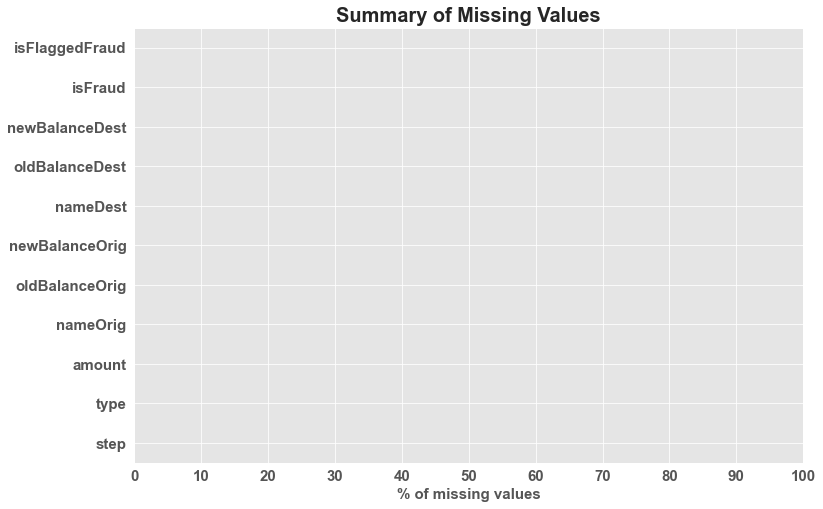

In [19]:
# visual summary of % of missing values in each column
(df.isna().sum() / df.shape[0] * 100)\
    .sort_values()\
    .plot(kind='barh', figsize=(12,8))
plt.xticks(np.arange(0,110,10), fontsize=15, fontweight='bold')
plt.xlabel("% of missing values", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Summary of Missing Values", fontsize=20, fontweight='bold')
plt.show()

### Observations:
<br/>
Data is clean and no missing values

# Feature Engineering

In [20]:
# transaction hour
df['transactionHour'] = df['step'] % 24

# converting into object type
df['transactionHour'] = df['transactionHour'].astype('object')

In [21]:
# transaction amount in thousands
df['th_amount'] = df['amount'] / 1000

In [22]:
# transaction type
df['transactionBetween'] = df['nameDest'].apply(lambda x: 'Customer2Customer' if x[0] == "C" else 'Customer2Merchant')

In [23]:
# transaction period (Categorizing the hour value into peak hour, mid hour, and least hour based on the proportion of fraud happening.)
df['transactionPeriod'] = df['transactionHour'].apply(lambda x: 'Peak' if x in [2,3,4,5,6] else
                                                                ('Mid' if x in [22,23,0,1,7,8] else 'Safe'))

## Error in origin account balance amount
Manually calculating the error in origin account balance amount after transaction.

Error = (New Balance + Transaction Amount) - Old Balance

If,
Transaction Amount = (Old Balance - New Balance), then zero error value.
Transaction Amount > (Old Balance - New Balance), then negative value.
* Transaction Amount < (Old Balance - New Balance), then positive value.

NOTE: This applies only for outgoing transactions.

In [24]:
# origin balance error
df['errorBalanceOrig'] = df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']

## Error in destination account balance amount
Manually calculating the error in destination account balance amount after transaction.

Error = (Old Balance + Transaction Amount) - New Balance

If,
Transaction Amount = (New Balance - Old Balance), then zero error value.
Transaction Amount > (New Balance - Old Balance), then positive value.
* Transaction Amount < (New Balance - Old Balance), then negative value.

NOTE: This applies only for outgoing transactions.

In [25]:
# destination balance error
df['errorBalanceDest'] = df['oldBalanceDest'] + df['amount'] - df['newBalanceDest']

In [26]:
# flag to indicate whether both old and new balance in origin account are zero
df['zeroBalanceOrig'] = df['oldBalanceOrig'] + df['newBalanceOrig']
df['zeroBalanceOrig'] = df['zeroBalanceOrig'].apply(lambda x: 1 if x == 0 else 0)

In [27]:
# flag to indicate whether both old and new balance in destination account are zero
df['zeroBalanceDest'] = df['oldBalanceDest'] + df['newBalanceDest']
df['zeroBalanceDest'] = df['zeroBalanceDest'].apply(lambda x: 1 if x == 0 else 0)

# Exploratory Data Analysis 

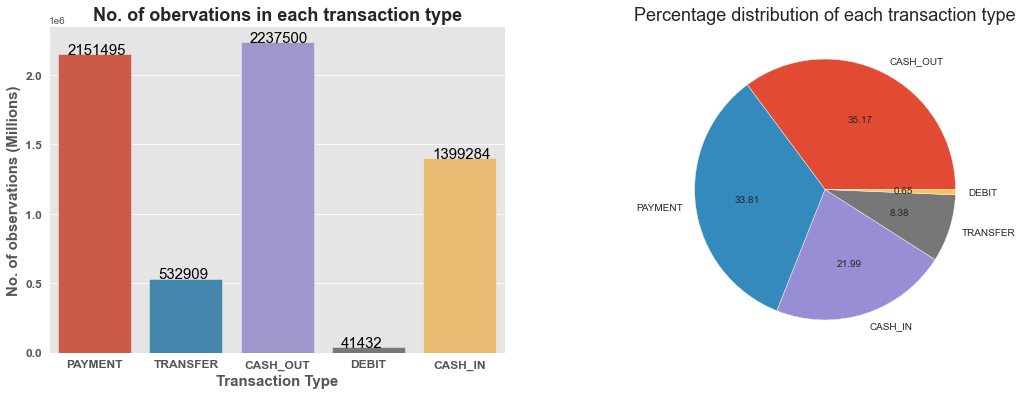

In [28]:
# transaction type
plt.subplots(1,2, figsize=(18,6))

# countplot to visualize the no. of observations under each class
plt.subplot(1,2,1)
ax = sns.countplot(df['type'])
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel('No. of observations (Millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each transaction type', fontsize=18, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.1, i.get_height(), str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(df['type'].value_counts(), labels=['CASH_OUT','PAYMENT','CASH_IN','TRANSFER','DEBIT'], autopct='%.2f')
plt.title('Percentage distribution of each transaction type', fontsize=18)

# display plot
plt.show()

### Observations:

Majority of the transactions are of Payment and Cash-Out types (~34%).
<br/>
Debit transactions are the least, less than 1%.

In [29]:
# least transaction amount
print("Least amount transacted:", df['amount'].min());print()

# highest transaction amount
print("Highest amount transacted:", df['amount'].max()); print()

# highest transaction amount for each transaction type
print("Highest amount transacted in each transaction type:")
for t_type in df['type'].unique():
    print(f"\t* Highest amount transacted in {t_type} type is {df.loc[(df['type'] == t_type), 'amount'].max()}")

Least amount transacted: 0.0

Highest amount transacted: 92445516.64

Highest amount transacted in each transaction type:
	* Highest amount transacted in PAYMENT type is 238637.98
	* Highest amount transacted in TRANSFER type is 92445516.64
	* Highest amount transacted in CASH_OUT type is 10000000.0
	* Highest amount transacted in DEBIT type is 569077.51
	* Highest amount transacted in CASH_IN type is 1915267.9


### Observations:

Transfer transactions are having highest transactions amounts.
<br/>
Debit transactions are having the least highest transaction amount.

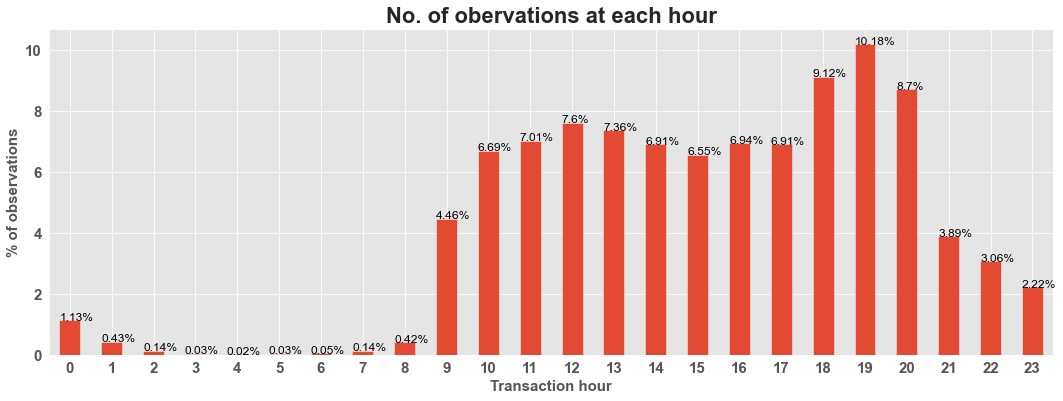

In [30]:
# number of transactions in each hour
plt.figure(figsize=(18,6))
ax = (df['transactionHour'].value_counts(sort=False, normalize=True) * 100).round(2).plot(kind='bar')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)) + "%", fontsize=12, color='black')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% of observations', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. of obervations at each hour', fontsize=22, fontweight='bold')
plt.show()


### Observations:

Number of transactions gradually increase from 9 hrs, peaking at 19 hrs, and then gradually decrease.
<br/>
Majority of transactions happen during day.

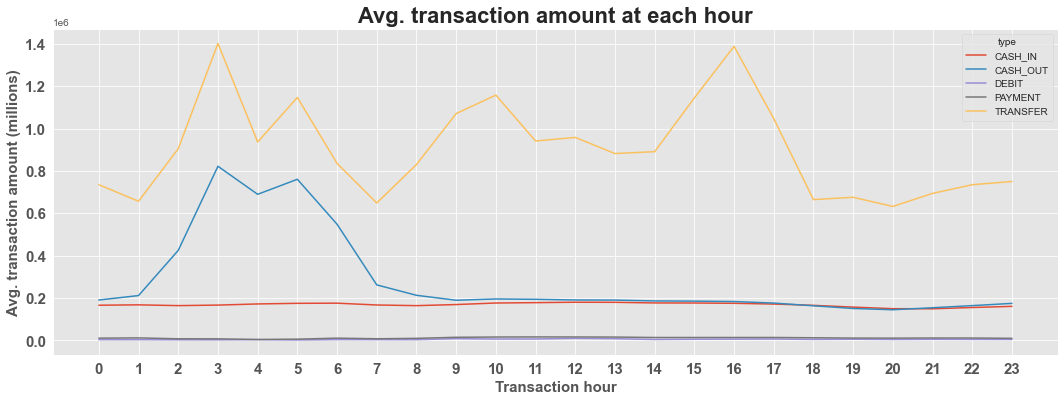

In [31]:
# avg. transaction amount at each hour for each transaction type
plt.figure(figsize=(18,6))
sns.lineplot(data=df.groupby(['transactionHour','type']).agg({'amount' : 'mean'}).round(2).reset_index(),
             x='transactionHour',
             y='amount',
             hue='type')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('Avg. transaction amount (millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Avg. transaction amount at each hour', fontsize=22, fontweight='bold')
plt.show()

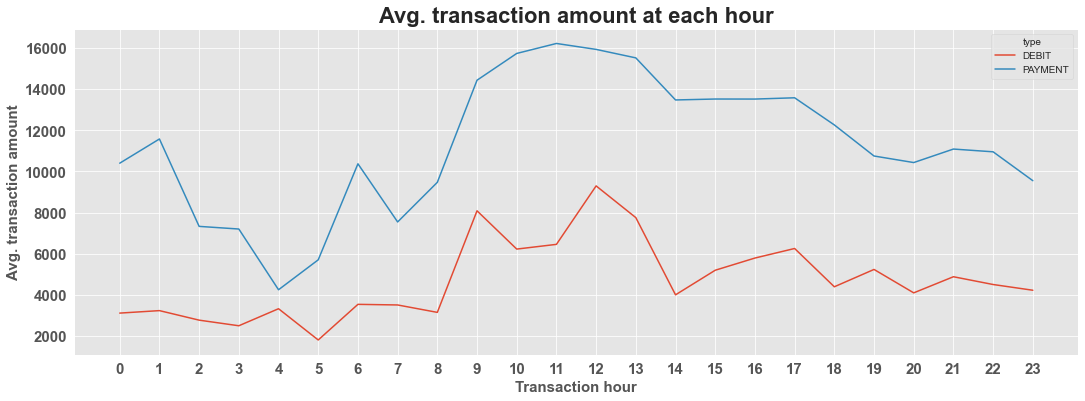

In [32]:
# avg. transaction amount at each hour for each transaction type
plt.figure(figsize=(18,6))
sns.lineplot(data=df[df['type'].isin(['DEBIT','PAYMENT'])].groupby(['transactionHour','type']).agg({'amount' : 'mean'}).round(2).reset_index(),
             x='transactionHour',
             y='amount',
             hue='type')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('Avg. transaction amount', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Avg. transaction amount at each hour', fontsize=22, fontweight='bold')
plt.show()

### Observations:

Average amount for Transfer type transactions peak at 3 hrs and 16 hrs. That's strange.
<br/>
Average amount for Cash-Out type transactions peak between 3 hrs and 5 hrs.
<br/>
Average amount for Cash-In type transactions is stable through out the day.
<br/>
Average amount for Debit and Payment type transactions peak between 9 hrs and 13 hrs.

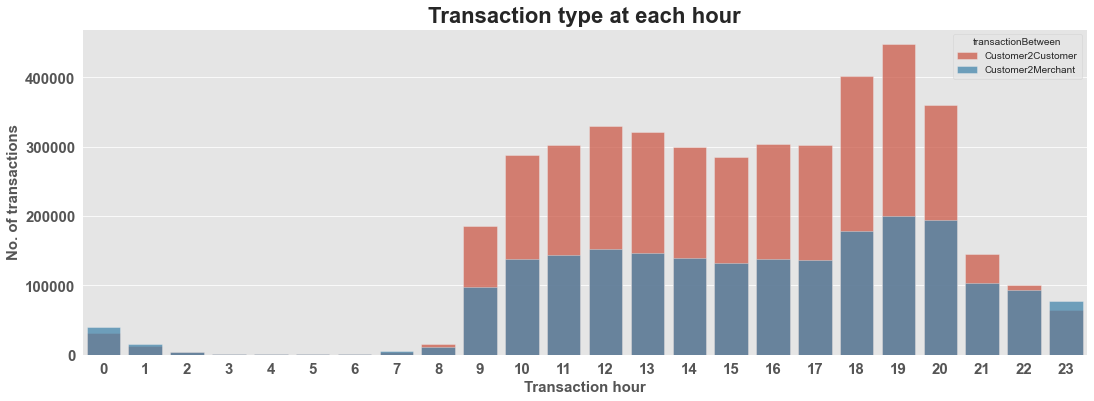

In [33]:
# avg. transaction amount at each hour for each transaction type
plt.figure(figsize=(18,6))
sns.barplot(data=df.groupby(['transactionHour','transactionBetween']).size().reset_index(),
            x='transactionHour',
            y=0,
            hue='transactionBetween',
            dodge=False,
            alpha=0.75)
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('No. of transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Transaction type at each hour', fontsize=22, fontweight='bold')
plt.show()

### Observations:

During day, Customer to Customer transactions are greater than Customer to Merchant transactions.
<br/>
During mid-night, Customer to Merchant transactions are greater than Customer to Customer transactions.

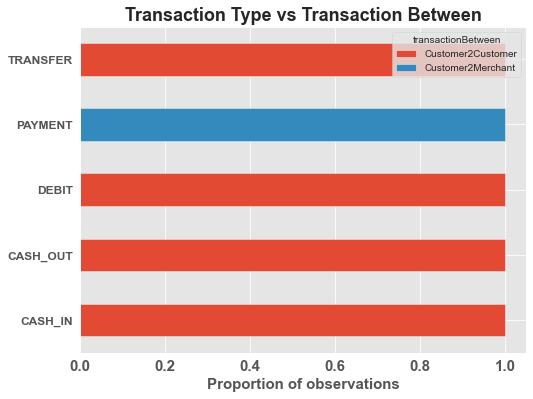

In [34]:
# transaction type vs transaction between
plt.figure(figsize=(8,6))
pd.crosstab(df['type'], df['transactionBetween'], normalize=0).plot(kind='barh', stacked=True, ax=plt.gca())
plt.xlabel('Proportion of observations', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold')
plt.ylabel('', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Transaction Type vs Transaction Between', fontsize=18, fontweight='bold')
plt.show()

### Observations:

Customer to Merchant transactions are Payment type only.
<br/>
Remaining transaction types are between Customer to Customer only.

In [35]:
# subsetting fraudulent transactions
df_fraud = df[df['isFraud'] == 1].drop(columns=['isFlaggedFraud'])

# subsetting non-fraudulent transactions
df_nonfraud = df[(df['isFraud'] == 0) & (df['type'].isin(['CASH_OUT','TRANSFER']))].drop(columns=['isFlaggedFraud'])

# creating a new dataframe from sub-sampled data
df_new = pd.concat([df_fraud, df_nonfraud], axis=0)

# dataframe dimensions
print(f"The new sub-sampled dataframe has {df_new.shape[0]} rows and {df_new.shape[1]} columns.")

The new sub-sampled dataframe has 2770409 rows and 18 columns.


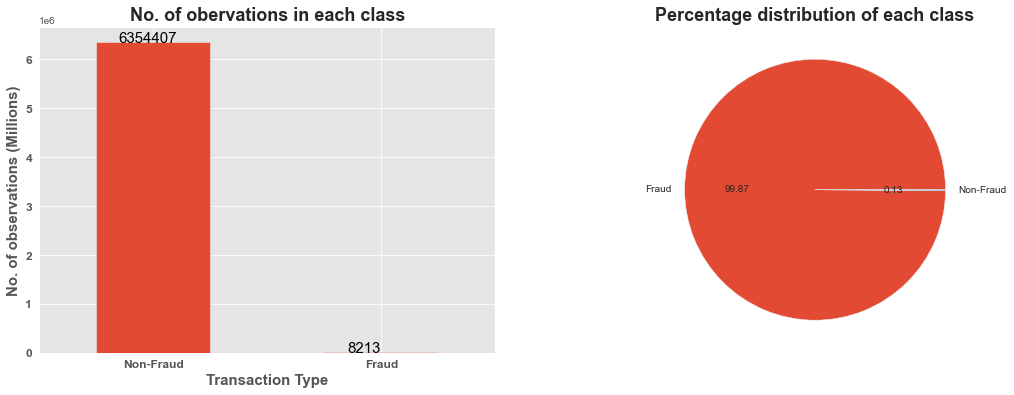

In [36]:
# fraudulent transactions
plt.subplots(1,2, figsize=(18,6))

# countplot to visualize the no. of observations under each class
plt.subplot(1,2,1)
ax = df['isFraud'].value_counts().plot(kind='bar')
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(ticks=[0,1], labels=['Non-Fraud','Fraud'], rotation=0, fontsize=12, fontweight='bold')
plt.ylabel('No. of observations (Millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each class', fontsize=18, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(df['isFraud'].value_counts(), labels=['Fraud','Non-Fraud'], autopct='%.2f')
plt.title('Percentage distribution of each class', fontsize=18, fontweight='bold')

# display plot
plt.show()

### Observations:

Fraudulent transaction observations are only 8,213 (0.13%). Fraud is rare.

In [38]:
# min and max fraud transaction amount
print("Min fraud transaction amount:", df_fraud['amount'].min());print()
print("Max fraud transaction amount:", df_fraud['amount'].max())

Min fraud transaction amount: 0.0

Max fraud transaction amount: 10000000.0


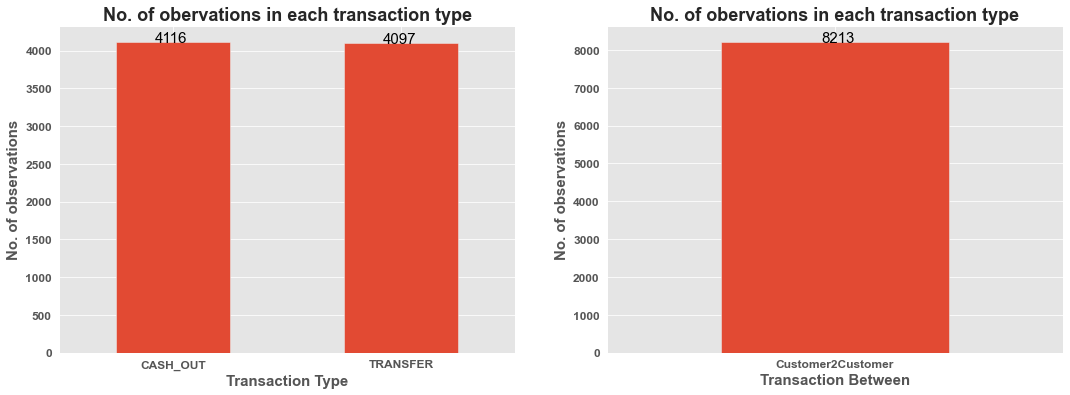

In [39]:
# where does fraud happen?
plt.subplots(1,2, figsize=(18,6))

# transaction type
plt.subplot(1,2,1)
ax=df_fraud.groupby('type').size().plot(kind='bar')
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylabel('No. of observations', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each transaction type', fontsize=18, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.17, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

# transaction between
plt.subplot(1,2,2)
ax=df_fraud.groupby('transactionBetween').size().plot(kind='bar')
plt.xlabel('Transaction Between', fontsize=15, fontweight='bold')
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylabel('No. of observations', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each transaction type', fontsize=18, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.22, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

plt.show()

### Observations:

Fraudulent transactions were recored only in Cash-Out and Transfer transaction types. They are equally distributed.
<br/>
Also, fraudulent transactions were recored only in Customer to Customer transactions.

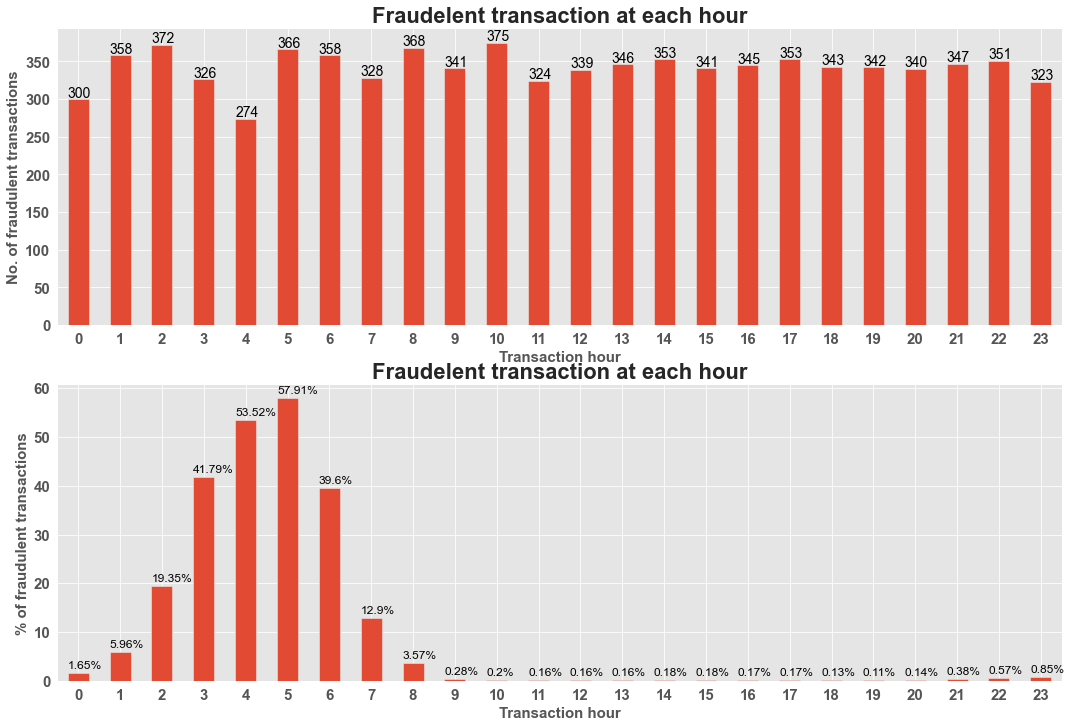

In [40]:
# when does fraud happen? (time of day)
plt.subplots(2,1, figsize=(18,12))

# actual count of fraud cases
plt.subplot(2,1,1)
ax=df_fraud.groupby('transactionHour').size().plot(kind='bar')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('No. of fraudulent transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Fraudelent transaction at each hour', fontsize=22, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+3, str(round(i.get_height(), 2)), fontsize=14, color='black')
    
# proportion of fraud
plt.subplot(2,1,2)
ax=(df_fraud.groupby('transactionHour').size() / df_new.groupby('transactionHour').size() * 100).plot(kind='bar')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% of fraudulent transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Fraudelent transaction at each hour', fontsize=22, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+1, str(round(i.get_height(), 2))+"%", fontsize=12, color='black')

plt.show()

### Obseravations:

Proportion of fraudulent transactions is gradually increasing from 9:00 pm, peaks at 5:00 am (~58%, thats huge!) and then gradually decreases.

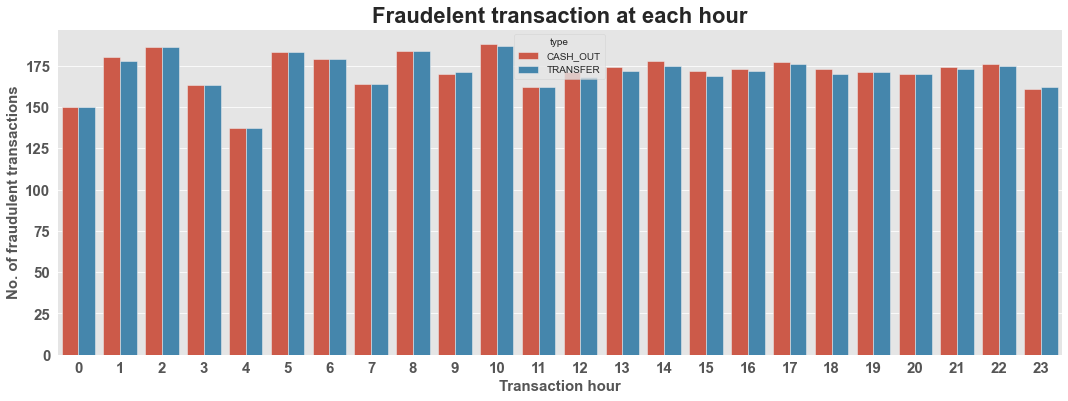

In [41]:
# when does fraud happen? (time of day)
plt.figure(figsize=(18,6))
ax=sns.barplot(data=df_fraud.groupby(['transactionHour','type']).size().reset_index(),
               x='transactionHour',
               y=0,
               hue='type')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('No. of fraudulent transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Fraudelent transaction at each hour', fontsize=22, fontweight='bold')
plt.show()

### Observations:

There is no visible difference in frequency of fraud between transaction types.

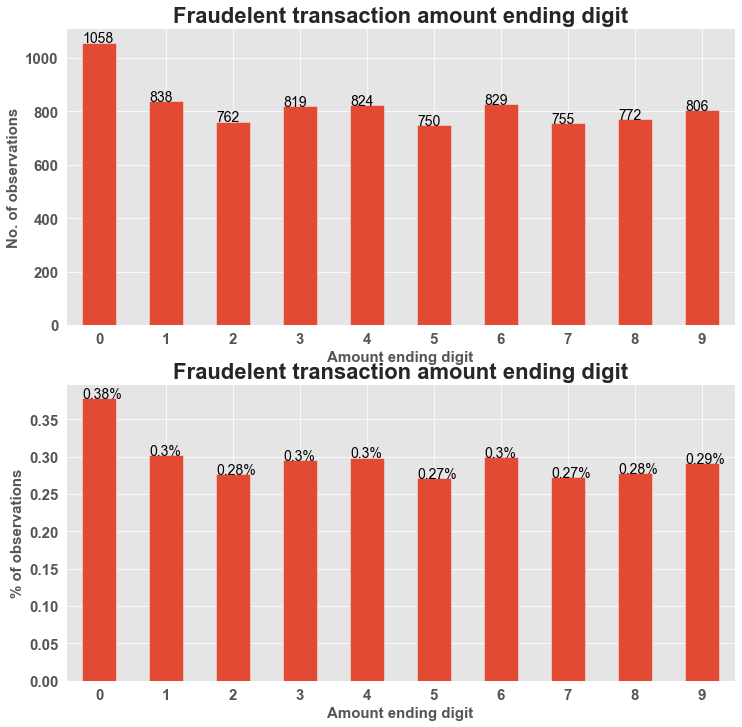

In [42]:
# fraudulent transaction amount last digit
plt.subplots(2,1, figsize=(12,12))

# actual counts
plt.subplot(2,1,1)
ax=np.floor(df_fraud['amount']).astype('str').str[-3].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Amount ending digit', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('No. of observations', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Fraudelent transaction amount ending digit', fontsize=22, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)), fontsize=14, color='black')

# proportion of fraud
plt.subplot(2,1,2)
ax=(np.floor(df_fraud['amount']).astype('str').str[-3].value_counts().sort_index() / np.floor(df_new['amount']).astype('str').str[-3].value_counts().sort_index() * 100).plot(kind='bar')
plt.xlabel('Amount ending digit', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% of observations', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Fraudelent transaction amount ending digit', fontsize=22, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2))+"%", fontsize=14, color='black')

plt.show()

### Observations:

Majority of fraudulent transactions have amount ending with digit 0.
<br/>
That's probably because, human beings tend to make up round numbers (10, 50, 100, etc) when they make up some numbers.
<br/>
Not much significant difference. We can ignore this feature.

In [43]:
# no. of fraud transactions per destination account
df_fraud.groupby('nameDest').size().value_counts().reset_index().rename(columns={'index':'No. of Fraudulent Transactions per Destination Account',
                                                                                 0:'No. of Unique Accounts'})

,No. of Fraudulent Transactions per Destination Account,No. of Unique Accounts
0,1,8125
1,2,44


In [44]:
# zero old and new destination balance, but with non-zero transaction amount
print("Proportion of fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in destination account are zero:",
      sum((df_fraud['oldBalanceDest'] == 0) & (df_fraud['newBalanceDest'] == 0) & (df_fraud['amount'] != 0)) / df_fraud.shape[0])
print()
print("Proportion of non fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in destination account are zero:",
      sum((df_nonfraud['oldBalanceDest'] == 0) & (df_nonfraud['newBalanceDest'] == 0) & (df_nonfraud['amount'] != 0)) / df_nonfraud.shape[0])

Proportion of fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in destination account are zero: 0.4955558261293072

Proportion of non fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in destination account are zero: 0.0006176245277308345


### Observations:

We can see that almost 50% of the fraudulent transactions had a zero old balance and new balance in destination account even through transaction amount was non-zero.
<br/>
But, less than 0.01% of the non fraudulent transactions had a zero old balance and new balance in destination account even through transaction amount was non-zero.

In [45]:
# zero old and new destination balance, but with non-zero transaction amount
print("Proportion of fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in origin account are zero:",
      sum((df_fraud['oldBalanceOrig'] == 0) & (df_fraud['newBalanceOrig'] == 0) & (df_fraud['amount'] != 0)) / df_fraud.shape[0])
print()
print("Proportion of non fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in origin account are zero:",
      sum((df_nonfraud['oldBalanceOrig'] == 0) & (df_nonfraud['newBalanceOrig'] == 0) & (df_nonfraud['amount'] != 0)) / df_nonfraud.shape[0])

Proportion of fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in origin account are zero: 0.0030439547059539756

Proportion of non fraudulent transactions where transaction amount is non-zero, but both old balance and new balance in origin account are zero: 0.4737321319703598


In [46]:
# error in origin account balance
print("Proportion of fraudulent transactions where transaction amount is non-zero, and there is an error in origin account balance amount:",
      sum((df_fraud['errorBalanceOrig'] != 0) & (df_fraud['amount'] != 0)) / df_fraud.shape[0])
print()
print("Proportion of non fraudulent transactions where transaction amount is non-zero, and there is an error in origin account balance amount:",
      sum((df_nonfraud['errorBalanceOrig'] != 0) & (df_nonfraud['amount'] != 0)) / df_nonfraud.shape[0])

Proportion of fraudulent transactions where transaction amount is non-zero, and there is an error in origin account balance amount: 0.006940216729575064

Proportion of non fraudulent transactions where transaction amount is non-zero, and there is an error in origin account balance amount: 0.9124529903019192


In [47]:
# error in destination account balance
print("Proportion of fraudulent transactions where transaction amount is non-zero, and there is an error in destination account balance amount:",
      sum((df_fraud['errorBalanceDest'] != 0) & (df_fraud['amount'] != 0)) / df_fraud.shape[0])
print()
print("Proportion of non fraudulent transactions where transaction amount is non-zero, and there is an error in destination account balance amount:",
      sum((df_nonfraud['errorBalanceDest'] != 0) & (df_nonfraud['amount'] != 0)) / df_nonfraud.shape[0])

Proportion of fraudulent transactions where transaction amount is non-zero, and there is an error in destination account balance amount: 0.6482405941799586

Proportion of non fraudulent transactions where transaction amount is non-zero, and there is an error in destination account balance amount: 0.42026706287316323


In [48]:
# average error in origin account balance
print("Average absolute error in origin account balance amount in fraudulent data:", round(abs(df_fraud['errorBalanceOrig']).mean(),2))
print()
print("Average absolute error in origin account balance amount in non fraudulent data:", round(abs(df_nonfraud['errorBalanceOrig']).mean(), 2))

Average absolute error in origin account balance amount in fraudulent data: 10692.33

Average absolute error in origin account balance amount in non fraudulent data: 286803.51


In [49]:
# average error in destination account balance
print("Average absolute error in destination account balance amount in fraudulent data:", round(abs(df_fraud['errorBalanceDest']).mean(), 2))
print()
print("Average absolute error in destination account balance amount in non fraudulent data:", round(abs(df_nonfraud['errorBalanceDest']).mean(), 2))

Average absolute error in destination account balance amount in fraudulent data: 745138.59

Average absolute error in destination account balance amount in non fraudulent data: 44302.66


### Observations:

Fraudulent transactions, in general, are having lower error in origin account balance and higher error in destination account balance at the end of transaction.

# Data Preprocessing

Summary statistics:
 count     2770409.00
mean       317536.14
std        887789.66
min             0.00
25%         82973.54
50%        171260.93
75%        306791.18
max      92445516.64
Name: amount, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  21.93


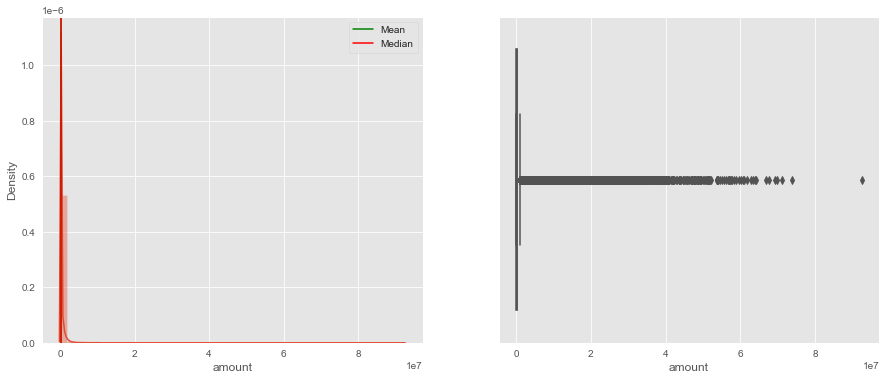

In [50]:
# Transaction amount
# summary statistics
print("Summary statistics:\n", df_new['amount'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_new['amount'].skew().round(2))

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_new['amount'])
plt.axvline(df_new['amount'].mean(), color="g", label="Mean")
plt.axvline(df_new['amount'].median(), color="r", label="Median")
plt.legend()

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_new['amount'], whis=3)

# display plot
plt.show()


Summary statistics:
 count    2770409.00
mean           5.04
std            1.19
min            0.00
25%            4.43
50%            5.15
75%            5.73
max           11.43
Name: th_amount, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  -0.42


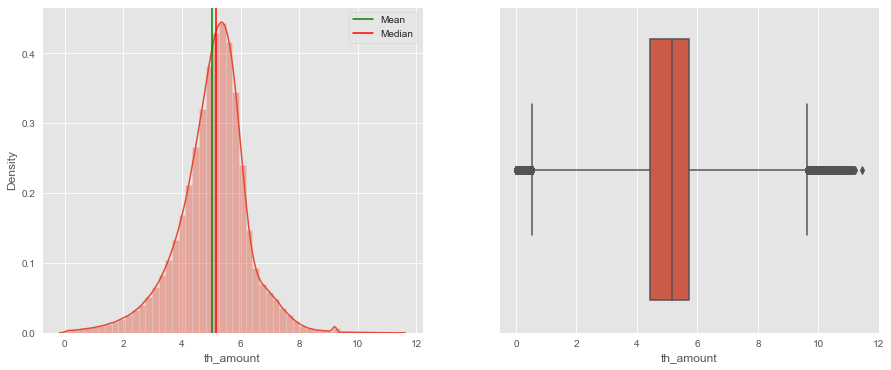

In [51]:
# summary statistics
print("Summary statistics:\n", np.log1p(df_new['th_amount']).describe().round(2))
print("-"*100)

# skewness
print("Skew: ", np.log1p(df_new['th_amount']).skew().round(2))

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(np.log1p(df_new['th_amount']))
plt.axvline(np.log1p(df_new['th_amount']).mean(), color="g", label="Mean")
plt.axvline(np.log1p(df_new['th_amount']).median(), color="r", label="Median")
plt.legend()

# boxplot
plt.subplot(1,2,2)
sns.boxplot(np.log1p(df_new['th_amount']), whis=3)

# display plot
plt.show()

### Observations:

Applying log transformation on the amount is removing skewness.
<br/>
Outliers also reduced after applying log transformation.

In [52]:
# log transformed amount
df_new['ln_amount'] = np.log1p(df_new['th_amount'])

Summary statistics:
 count     2770409.00
mean       285984.97
std        875322.99
min            -0.01
25%         51853.10
50%        143597.06
75%        279891.16
max      92445516.64
Name: errorBalanceOrig, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  22.68


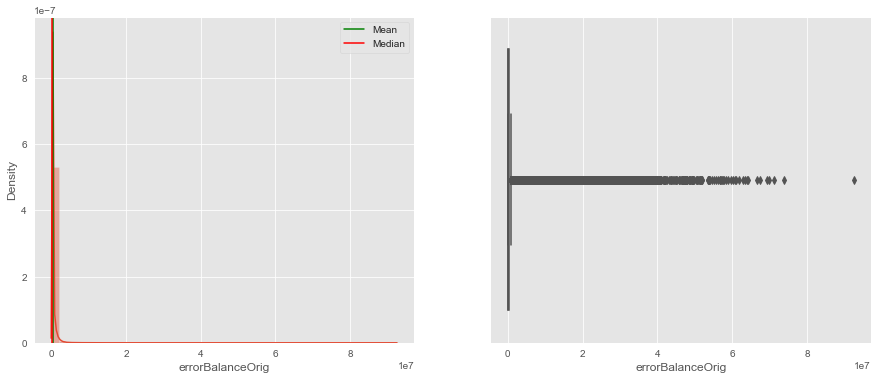

In [53]:
# Origin balance error
# summary statistics
print("Summary statistics:\n", df_new['errorBalanceOrig'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_new['errorBalanceOrig'].skew().round(2))

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_new['errorBalanceOrig'])
plt.axvline(df_new['errorBalanceOrig'].mean(), color="g", label="Mean")
plt.axvline(df_new['errorBalanceOrig'].median(), color="r", label="Median")
plt.legend()

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_new['errorBalanceOrig'], whis=3)

# display plot
plt.show()

In [54]:
# correcting few negative errors
df_new['errorBalanceOrig'] = df_new['errorBalanceOrig'].apply(lambda x: 0 if x < 0 else x)

Summary statistics:
 count    2770409.00
mean          10.68
std            3.79
min            0.00
25%           10.86
50%           11.87
75%           12.54
max           18.34
Name: errorBalanceOrig, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  -2.18


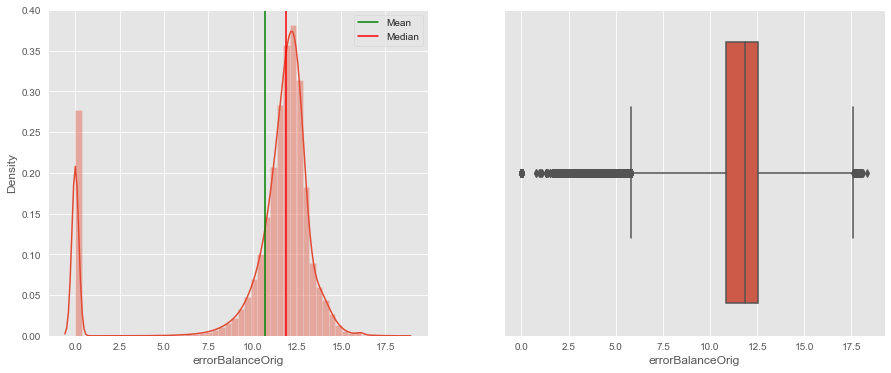

In [55]:
# summary statistics
print("Summary statistics:\n", np.log1p(df_new['errorBalanceOrig']).describe().round(2))
print("-"*100)

# skewness
print("Skew: ", np.log1p(df_new['errorBalanceOrig']).skew().round(2))

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(np.log1p(df_new['errorBalanceOrig']))
plt.axvline(np.log1p(df_new['errorBalanceOrig']).mean(), color="g", label="Mean")
plt.axvline(np.log1p(df_new['errorBalanceOrig']).median(), color="r", label="Median")
plt.legend()

# boxplot
plt.subplot(1,2,2)
sns.boxplot(np.log1p(df_new['errorBalanceOrig']), whis=3)

# display plot
plt.show()

### Observations:

Applying log transformation on the amount is removing skewness.
<br/>
There are still some outliers after applying log transformation.

In [56]:
# log transformed origin account balance error
df_new['ln_errorBalanceOrig'] = np.log1p(df_new['errorBalanceOrig'])

In [57]:
#Destination account balance error
# summary statistics
print("Summary statistics:\n", df_new['errorBalanceDest'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_new['errorBalanceDest'].skew().round(2))

Summary statistics:
 count     2770409.00
mean       -28647.13
std        593479.44
min     -75885725.63
25%             0.00
50%             0.00
75%             0.00
max      10000000.00
Name: errorBalanceDest, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  -44.08


In [58]:
# summary statistics
print("Summary statistics:\n", np.log1p(df_new['errorBalanceDest']).describe().round(2))
print("-"*100)

# skewness
print("Skew: ", np.log1p(df_new['errorBalanceDest']).skew().round(2))

Summary statistics:
 count    2601431.00
mean           0.46
std            2.28
min           -0.01
25%            0.00
50%            0.00
75%            0.00
max           16.12
Name: errorBalanceDest, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  4.86


### Observations:

Applying log transformation on the amount is removing skewness.

In [59]:
# log transformed origin account balance error
df_new['ln_errorBalanceDest'] = np.log1p(df_new['errorBalanceDest'])

# correcting errors
df_new['ln_errorBalanceDest'] = df_new['ln_errorBalanceDest'].apply(lambda x: 0 if x < 0 else x)
df_new['ln_errorBalanceDest'].fillna(0, inplace=True)

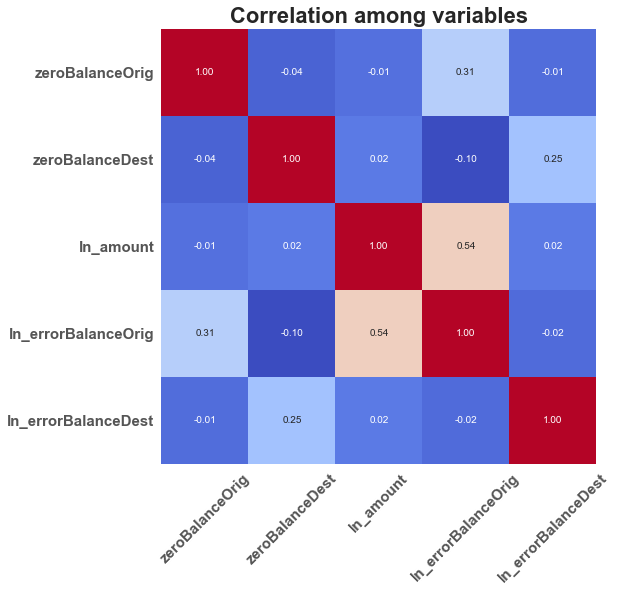

In [60]:
# Correlation plot
# heat map of correlation among variables
plt.figure(figsize=(8,8))
sns.heatmap(df_new.loc[:, 'zeroBalanceOrig':].corr(),
            fmt='.2f', annot=True, square=True, cmap='coolwarm', cbar=False)
plt.xticks(fontsize=15, fontweight='bold', rotation=45)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Correlation among variables', fontsize=22, fontweight='bold')
plt.show()

### Observations:

There are no visible correlations among variables, except for some correlation between amount and errorBalanceOrig.

## Subsetting final set of variables for modelling

In [61]:
# subsetting variables for modelling
df_model = df_new[['type', 'transactionPeriod',
                   'zeroBalanceOrig', 'zeroBalanceDest',
                   'ln_errorBalanceOrig', 'ln_errorBalanceDest', 'ln_amount',
                   'isFraud']]

# dataframe dimensions
print(f"The dataframe for modelling has {df_model.shape[0]} rows and {df_model.shape[1]} columns.")
print()
print("Features that are finally selected for our model:\n", list(df_model.columns)[:-1])

The dataframe for modelling has 2770409 rows and 8 columns.

Features that are finally selected for our model:
 ['type', 'transactionPeriod', 'zeroBalanceOrig', 'zeroBalanceDest', 'ln_errorBalanceOrig', 'ln_errorBalanceDest', 'ln_amount']


# Modelling
#### What is our objective?

We want to build some classification models to predict whether or not a transaction is fraudulent or not, based on the transaction data.

#### What is our cost (Type I/Type II)?

In this scenario, we do not want to incorrectly flag fraudulent transaction as non-fraudulent, i.e. incorrectly label (classify) a positive class as negative. Which is a false negative, i.e. Type II errors.

#### What are reliable validation metrics?

Type II errors: A lower number of Type II errors is desirable.

Recall: Recall is number of true positives out of actual positives. In general terms, it states that how well the model is able to differentiate between the two classes. A high recall value is desirable.

#### What is our optimizing criteria?

Keeping the accuracy and ROC AUC value as high as possible, we need to lower Type II errors or improve recall score.

## Splitting into train and test data

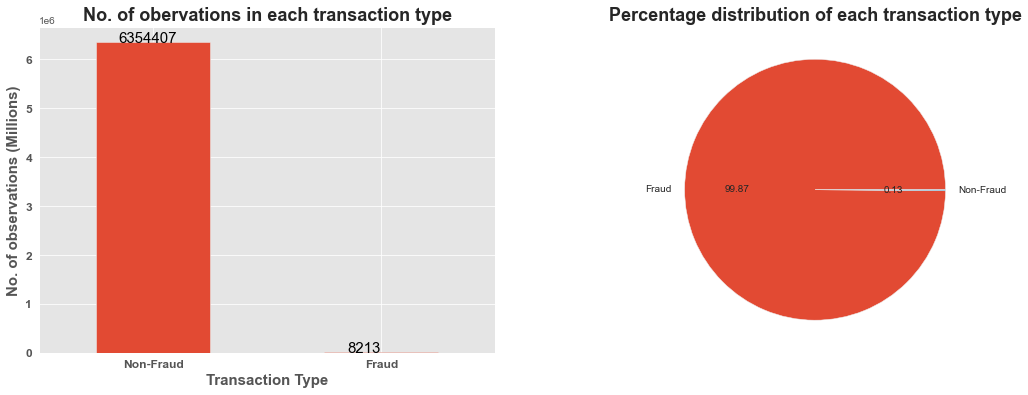

In [62]:
# class imbalance
plt.subplots(1,2, figsize=(18,6))

# countplot to visualize the no. of observations under each class
plt.subplot(1,2,1)
ax = df['isFraud'].value_counts().plot(kind='bar')
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(ticks=[0,1], labels=['Non-Fraud','Fraud'], rotation=0, fontsize=12, fontweight='bold')
plt.ylabel('No. of observations (Millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each transaction type', fontsize=18, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(df['isFraud'].value_counts(), labels=['Fraud','Non-Fraud'], autopct='%.2f')
plt.title('Percentage distribution of each transaction type', fontsize=18, fontweight='bold')

# display plot
plt.show()

In [63]:
# identifying dependent and independent features
X = df_model.loc[:, :'ln_amount']
y = df_model['isFraud']

# splitting data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [64]:
# creating train and test dataframes
df_train = X_train
df_train['isFraud'] = y_train

df_test = X_test
df_test['isFraud'] = y_test

# dataframe dimensions
print(f"Dimensions of original train set: {df_train.shape[0]} rows and {df_train.shape[1]} columns")
print(f"Dimensions of original test set: {df_test.shape[0]} rows and {df_test.shape[1]} columns")

Dimensions of original train set: 2216327 rows and 8 columns
Dimensions of original test set: 554082 rows and 8 columns


In [65]:
# down-sampling majority class
df_train_downsampled = df_train[df_train['isFraud'] == 0].sample(250000, random_state=1)

In [66]:
# down sampling majority class
df_train_downsampled_bootstrap = pd.concat([df_train_downsampled, df_train[df_train['isFraud'] == 1].sample(250000, replace=True, random_state=1)],
                                           axis=0)
 
# dataframe dimensions
print(f"After downsampling the majority class and upsampling the minority class using bootstrap, the balanced train set has {df_train_downsampled_bootstrap.shape[0]} rows and {df_train_downsampled_bootstrap.shape[1]} columns.")

After downsampling the majority class and upsampling the minority class using bootstrap, the balanced train set has 500000 rows and 8 columns.


In [67]:
# appending the fraud data
df_train_downsampled = pd.concat([df_train_downsampled, df_train[df_train['isFraud'] == 1]])

# dataframe dimensions
print(f"After downsampling the majority class, imbalanced train set has {df_train_downsampled.shape[0]} rows and {df_train_downsampled.shape[1]} columns.")

After downsampling the majority class, imbalanced train set has 256570 rows and 8 columns.


### Over-sampling using SMOTE

In [72]:
from imblearn.over_sampling import ADASYN, SMOTE
# preprocessing data for SMOTE
X_train_smote = df_train_downsampled[['zeroBalanceOrig', 'zeroBalanceDest', 'ln_errorBalanceOrig', 'ln_errorBalanceDest', 'ln_amount']].round(3)

X_train_smote['type_Transfer'] = df_train_downsampled['type'].replace({'CASH_OUT' : 0,
                                                                       'TRANSFER' : 1})

X_train_smote['transactionPeriod_Mid'] = df_train_downsampled['transactionPeriod'].apply(lambda x: 1 if x == 'Mid' else 0)
X_train_smote['transactionPeriod_Peak'] = df_train_downsampled['transactionPeriod'].apply(lambda x: 1 if x == 'Peak' else 0)

# initializing SMOTE object
smote = SMOTE(random_state=33)

# fitting data with SMOTE and creating synthetic over-sampled data set
X, y = smote.fit_resample(X_train_smote, df_train_downsampled['isFraud'])

# concatnating data and creating train df
df_train_downsampled_smote = pd.concat([X, y], axis=1)

# shuffling data
df_train_downsampled_smote = df_train_downsampled_smote.sample(frac=1, random_state=1)

# dataframe dimensions
print(f"After downsampling the majority class and upsampling the minority class using SMOTE, the balanced train set has {df_train_downsampled_smote.shape[0]} rows and {df_train_downsampled_smote.shape[1]} columns.")

After downsampling the majority class and upsampling the minority class using SMOTE, the balanced train set has 500000 rows and 9 columns.


## Encoding and scaling variables

In [73]:
# initializing standard scaler
ss = StandardScaler()

# fitting scaler on train data
ss.fit(df_train_downsampled[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']])

# standardizing test data
X_test = pd.DataFrame(ss.transform(df_test[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']]),
                      columns=['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount'])

# creating dummies for test data
X_test['zeroBalanceOrig'] = df_test['zeroBalanceOrig'].reset_index(drop=True)
X_test['zeroBalanceDest'] = df_test['zeroBalanceDest'].reset_index(drop=True)

X_test['type_Transfer'] = df_test['type'].replace({'CASH_OUT' : 0,
                                                   'TRANSFER' : 1})\
                                         .reset_index(drop=True)
X_test['transactionPeriod_Mid'] = df_test['transactionPeriod'].apply(lambda x: 1 if x == 'Mid' else 0)\
                                                              .reset_index(drop=True)
X_test['transactionPeriod_Peak'] = df_test['transactionPeriod'].apply(lambda x: 1 if x == 'Peak' else 0)\
                                                               .reset_index(drop=True)

# target variable
y_test = df_test['isFraud'].reset_index(drop=True)

# dataframe shape
print(f"After standardizing and encoding the test data, this dataframe has {X_test.shape[0]} rows and {X_test.shape[1]} columns.")

# df_train_downsampled_bootstrap
# standardizing train data
X_train_downsampled_bootstrap = pd.DataFrame(ss.transform(df_train_downsampled_bootstrap[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']]),
                                             columns=['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount'])

# creating dummies for test data
X_train_downsampled_bootstrap['zeroBalanceOrig'] = df_train_downsampled_bootstrap['zeroBalanceOrig']\
                                                        .reset_index(drop=True)
X_train_downsampled_bootstrap['zeroBalanceDest'] = df_train_downsampled_bootstrap['zeroBalanceDest']\
                                                        .reset_index(drop=True)

X_train_downsampled_bootstrap['type_Transfer'] = df_train_downsampled_bootstrap['type'].replace({'CASH_OUT' : 0,
                                                                                                 'TRANSFER' : 1})\
                                                                                       .reset_index(drop=True)

X_train_downsampled_bootstrap['transactionPeriod_Mid'] = df_train_downsampled_bootstrap['transactionPeriod']\
                                                            .apply(lambda x: 1 if x == 'Mid' else 0)\
                                                            .reset_index(drop=True)
X_train_downsampled_bootstrap['transactionPeriod_Peak'] = df_train_downsampled_bootstrap['transactionPeriod']\
                                                            .apply(lambda x: 1 if x == 'Peak' else 0)\
                                                            .reset_index(drop=True)
# target variable
y_train_downsampled_bootstrap = df_train_downsampled_bootstrap['isFraud'].reset_index(drop=True)

# dataframe shape
print(f"After standardizing and encoding the down-sampled and bootstrapped train data, this dataframe has {X_train_downsampled_bootstrap.shape[0]} rows and {X_train_downsampled_bootstrap.shape[1]} columns.")

# df_train_downsampled_smote
# standardizing train data
X_train_downsampled_smote = pd.DataFrame(ss.transform(df_train_downsampled_smote[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']]),
                                         columns=['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount'])

# dummies
X_train_downsampled_smote['zeroBalanceOrig'] = df_train_downsampled_smote['zeroBalanceOrig'].reset_index(drop=True)
X_train_downsampled_smote['zeroBalanceDest'] = df_train_downsampled_smote['zeroBalanceDest'].reset_index(drop=True)
X_train_downsampled_smote['type_Transfer'] = df_train_downsampled_smote['type_Transfer'].reset_index(drop=True)
X_train_downsampled_smote['transactionPeriod_Mid'] = df_train_downsampled_smote['transactionPeriod_Mid'].reset_index(drop=True)
X_train_downsampled_smote['transactionPeriod_Peak'] = df_train_downsampled_smote['transactionPeriod_Peak'].reset_index(drop=True)

# target variable
y_train_downsampled_smote = df_train_downsampled_smote['isFraud'].reset_index(drop=True)

# dataframe shape
print(f"After standardizing and encoding the down-sampled and synthetic over-sampled train data, this dataframe has {X_train_downsampled_smote.shape[0]} rows and {X_train_downsampled_smote.shape[1]} columns.")

After standardizing and encoding the test data, this dataframe has 554082 rows and 8 columns.
After standardizing and encoding the down-sampled and bootstrapped train data, this dataframe has 500000 rows and 8 columns.
After standardizing and encoding the down-sampled and synthetic over-sampled train data, this dataframe has 500000 rows and 8 columns.


In [74]:
# shuffling data
X_train_downsampled_bootstrap = X_train_downsampled_bootstrap.sample(frac=1, random_state=33)
y_train_downsampled_bootstrap = y_train_downsampled_bootstrap.sample(frac=1, random_state=33)

X_train_downsampled_smote = X_train_downsampled_smote.sample(frac=1, random_state=33)
y_train_downsampled_smote = y_train_downsampled_smote.sample(frac=1, random_state=33)

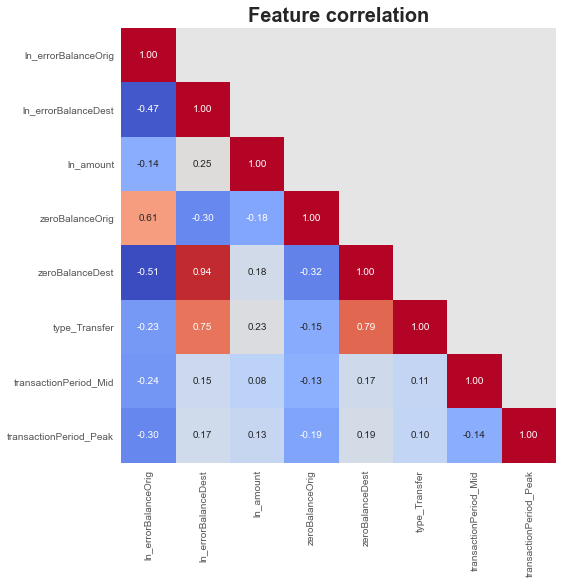

In [75]:
# correlated features
plt.figure(figsize=(8,8))
sns.heatmap(X_train_downsampled_bootstrap.corr(),
            annot = True, square = True, fmt = ".2f",
            cmap = "coolwarm", cbar = False, mask = np.triu(X_train_downsampled_bootstrap.corr(), 1))
plt.title("Feature correlation", fontsize=20, fontweight='bold')
# display plot
plt.show()

In [76]:
# calculating vif values
vif = [variance_inflation_factor(X_train_downsampled_bootstrap.values,i)
       for i in range(X_train_downsampled_bootstrap.shape[1])]

# displaying results as dataframe
pd.DataFrame({"VIF":vif}, index=X_train_downsampled_bootstrap.columns)\
        .sort_values("VIF", ascending=False)

,VIF
zeroBalanceDest,16.429447
ln_errorBalanceDest,11.847727
type_Transfer,4.210671
ln_errorBalanceOrig,2.334720
transactionPeriod_Mid,1.316842
transactionPeriod_Peak,1.308616
ln_amount,1.272875
zeroBalanceOrig,1.159461


### Observations:

There is some serious multicollinearity in the model features.
<br/>
From the EDA, we decide to drop ln_errorBalanceDest variable.

In [77]:
# dropping ln_errorBalanceDest
X_train_downsampled_bootstrap.drop(columns=['ln_errorBalanceDest'], inplace=True)
X_train_downsampled_smote.drop(columns=['ln_errorBalanceDest'], inplace=True)
X_test.drop(columns=['ln_errorBalanceDest'], inplace=True)

In [78]:
# calculating vif values
vif = [variance_inflation_factor(X_train_downsampled_bootstrap.values,i)
       for i in range(X_train_downsampled_bootstrap.shape[1])]

# displaying results as dataframe
pd.DataFrame({"VIF":vif}, index=X_train_downsampled_bootstrap.columns)\
        .sort_values("VIF", ascending=False)

,VIF
zeroBalanceDest,4.858736
type_Transfer,4.201379
ln_errorBalanceOrig,2.312307
transactionPeriod_Mid,1.314905
transactionPeriod_Peak,1.306897
ln_amount,1.181709
zeroBalanceOrig,1.157911


### Observations:

After dropping X_train_downsampled_smote, we have removed multi-collinearity from input variables.

In [79]:
# results matrix
df_results = pd.DataFrame(columns=['Description',
                                   'Misclassifications',
                                   'Type I errors',
                                   'Type II errors',
                                   'Precision',
                                   'Recall',
                                   'Accuracy',
                                   'F1-score',
                                   'ROC AUC'])

In [81]:
# defining function to implement stratified K-fold cross validation
def StratifiedKFoldCV(model, X_train, y_train, folds=5, threshold=0.5):
    
    # initializing dictionary to store cross validation results
    scores = {
        'train_accuracy' : [],
        'train_f1' : [],
        'train_roc_auc' : [],
        'test_accuracy' : [],
        'test_misclassification' : [],
        'test_type1' : [],
        'test_type2' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : [],
        'test_roc_auc' : []
    }

    # initializing the stratified K-fold splitter with n splits
    skf = StratifiedKFold(n_splits=folds)

    # accessing each train and test fold
    for train_index, test_index in skf.split(X_train, y_train):
        X1_train, X1_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y1_train, y1_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # fitting the model with train data
        model.fit(X1_train, y1_train)

        # predictions on training data
        scores['train_accuracy'].append(accuracy_score(y1_train, model.predict(X1_train)).round(2))
        scores['train_f1'].append(f1_score(y1_train, model.predict(X1_train)).round(2))
        scores['train_roc_auc'].append(roc_auc_score(y1_train, model.predict(X1_train)).round(2))

        # predicting the test data
        y1_pred = model.predict_proba(X1_test)
        y1_pred = binarize(y1_pred, threshold)[:,1]

        # predictions on test data
        tn, fp, fn, tp = confusion_matrix(y1_test, y1_pred).ravel()
        scores['test_type1'].append(fp)
        scores['test_type2'].append(fn)
        scores['test_misclassification'].append(fp + fn)
        scores['test_accuracy'].append(accuracy_score(y1_test, y1_pred).round(2))
        scores['test_precision'].append(precision_score(y1_test, y1_pred).round(2))
        scores['test_recall'].append(recall_score(y1_test, y1_pred).round(2))
        scores['test_f1'].append(f1_score(y1_test, y1_pred).round(2))
        scores['test_roc_auc'].append(roc_auc_score(y1_test, y1_pred).round(2))
        
    # returning the scores
    return scores

# Logistic regression
- Linear model
- Parametric model
- Simple model

In [82]:
# logit model with default hyperparameters
model_base = LogisticRegression(penalty='none')
model_base

LogisticRegression(penalty='none')

In [83]:
# evaluating model using K-fold cross validation
scores = StratifiedKFoldCV(model_base, X_train_downsampled_bootstrap, y_train_downsampled_bootstrap, 5)

In [84]:
# checking for overfitting
print(f"Train accuracy: {np.array(scores['train_accuracy']).mean().round(2)}\tTest accuracy: {np.array(scores['test_accuracy']).mean().round(2)}")
print(f"Train F1 score: {np.array(scores['train_f1']).mean().round(2)}\tTest F1 score: {np.array(scores['test_f1']).mean().round(2)}")
print(f"Train ROC AUC: {np.array(scores['train_roc_auc']).mean().round(2)}\tTest ROC AUC: {np.array(scores['test_roc_auc']).mean().round(2)}")

Train accuracy: 0.95	Test accuracy: 0.95
Train F1 score: 0.95	Test F1 score: 0.95
Train ROC AUC: 0.95	Test ROC AUC: 0.95


### Observations:

Train and test scores are similar, there is no model over-fit.

In [85]:
# itereation results
description = "Base logit model on bootstrapped data"
misclassifications = int(np.array(scores['test_misclassification']).mean())
type1 = int(np.array(scores['test_type1']).mean().round())
type2 = int(np.array(scores['test_type2']).mean().round())
precision = np.array(scores['test_precision']).mean().round(2)
recall = np.array(scores['test_recall']).mean().round(2)
accuracy = np.array(scores['test_accuracy']).mean().round(2)
f1 = np.array(scores['test_f1']).mean().round(2)
auc = np.array(scores['test_roc_auc']).mean().round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95


### Observations:

Looking at the results, our base logit model with default hyper parameters is performing well on training data.
<br/>
Examining the metrics of our interest, Recall score is 0.97, which is very high and is satisfactory.
<br/>
Will have to see how this model works on unseen (test) data.

### Base model on SMOTE data

In [87]:
# evaluating model using K-fold cross validation
scores = StratifiedKFoldCV(model_base, X_train_downsampled_smote, y_train_downsampled_smote, 5)

In [88]:
# checking for overfitting
print(f"Train accuracy: {np.array(scores['train_accuracy']).mean().round(2)}\tTest accuracy: {np.array(scores['test_accuracy']).mean().round(2)}")
print(f"Train F1 score: {np.array(scores['train_f1']).mean().round(2)}\tTest F1 score: {np.array(scores['test_f1']).mean().round(2)}")
print(f"Train ROC AUC: {np.array(scores['train_roc_auc']).mean().round(2)}\tTest ROC AUC: {np.array(scores['test_roc_auc']).mean().round(2)}")

Train accuracy: 0.95	Test accuracy: 0.95
Train F1 score: 0.95	Test F1 score: 0.95
Train ROC AUC: 0.95	Test ROC AUC: 0.95


### Observations:

Train and test scores are similar, there is no model over-fit.

In [89]:
# itereation results
description = "Base logit model on SMOTE data"
misclassifications = int(np.array(scores['test_misclassification']).mean())
type1 = int(np.array(scores['test_type1']).mean().round())
type2 = int(np.array(scores['test_type2']).mean().round())
precision = np.array(scores['test_precision']).mean().round(2)
recall = np.array(scores['test_recall']).mean().round(2)
accuracy = np.array(scores['test_accuracy']).mean().round(2)
f1 = np.array(scores['test_f1']).mean().round(2)
auc = np.array(scores['test_roc_auc']).mean().round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95


### Observations:

Comparing the results, training model on SMOTE data gave us slightly better results. That's probably because SMOTE technique induces some variation in data.
<br/>
Let's use SMOTE data for rest of our modelling.

## Hyper-parameter tuning

In [90]:
# hyper-parameter tuning
# creating hyperparameter grid
dict_params = {"penalty" : ['l1','l2'],
               "solver" : ['lbfgs', 'saga'],
               "C" : list(np.linspace(0.1, 2, 20))}

# hyperparameter tuning using grid search CV
model_tuning = GridSearchCV(model_base, param_grid=dict_params, scoring='recall', cv=5, return_train_score=True, n_jobs=-1)
model_tuning.fit(X_train_downsampled_smote, y_train_downsampled_smote)


GridSearchCV(cv=5, estimator=LogisticRegression(penalty='none'), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                               0.7999999999999999, 0.8999999999999999,
                               0.9999999999999999, 1.0999999999999999, 1.2, 1.3,
                               1.4, 1.5, 1.5999999999999999, 1.7, 1.8, 1.9,
                               2.0],
                         'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'saga']},
             return_train_score=True, scoring='recall')

In [91]:
# hyperparameter tuning results
cv_results = pd.DataFrame(model_tuning.cv_results_)
cv_results['train_test_diff'] = cv_results['mean_train_score'] - cv_results['mean_test_score']
cv_results.sort_values('mean_test_score', ascending=False)[["param_penalty","param_C","param_solver","mean_train_score","mean_test_score",'train_test_diff']].head()

,param_penalty,param_C,param_solver,mean_train_score,mean_test_score,train_test_diff
3,l2,0.1,saga,0.973669,0.973680,-0.000011
2,l2,0.1,lbfgs,0.973664,0.973676,-0.000012
6,l2,0.2,lbfgs,0.973641,0.973652,-0.000011
7,l2,0.2,saga,0.973641,0.973652,-0.000011
11,l2,0.3,saga,0.973509,0.973520,-0.000011


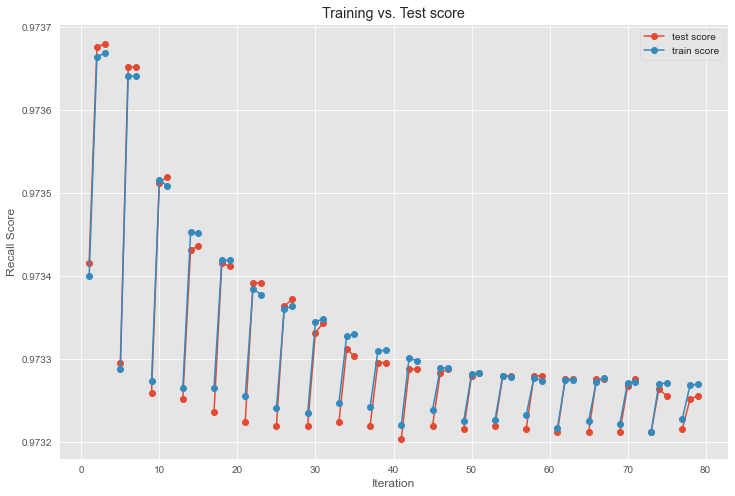

In [92]:
# visualizing training and testing accuracy
plt.figure(figsize=(12,8))
plt.plot(cv_results.index, cv_results["mean_test_score"], label="test score", marker='o')
plt.plot(cv_results.index, cv_results["mean_train_score"], label="train score", marker='o')
plt.title("Training vs. Test score")
plt.ylabel("Recall Score")
plt.xlabel("Iteration")
plt.legend()
plt.show()

### Observations:

From the CV results, there is no significant difference or improvement in model performance.
<br/>
Nevertheless, best model is model with l2 penalty, C = 0.1, solver = saga.

In [93]:
# optimized logit model
model_optimized = LogisticRegression(penalty='l2', C=0.1, solver='saga')
model_optimized

LogisticRegression(C=0.1, solver='saga')

In [94]:
# evaluating model using K-fold cross validation
scores = StratifiedKFoldCV(model_optimized, X_train_downsampled_bootstrap, y_train_downsampled_bootstrap, 5)

In [95]:
# checking for overfitting
print(f"Train accuracy: {np.array(scores['train_accuracy']).mean().round(2)}\tTest accuracy: {np.array(scores['test_accuracy']).mean().round(2)}")
print(f"Train F1 score: {np.array(scores['train_f1']).mean().round(2)}\tTest F1 score: {np.array(scores['test_f1']).mean().round(2)}")
print(f"Train ROC AUC: {np.array(scores['train_roc_auc']).mean().round(2)}\tTest ROC AUC: {np.array(scores['test_roc_auc']).mean().round(2)}")

Train accuracy: 0.95	Test accuracy: 0.95
Train F1 score: 0.95	Test F1 score: 0.95
Train ROC AUC: 0.95	Test ROC AUC: 0.95


### Observations:

Train and test scores are similar, there is no model over-fit.

In [96]:
# itereation results
description = "Optimized logit model"
misclassifications = int(np.array(scores['test_misclassification']).mean())
type1 = int(np.array(scores['test_type1']).mean().round())
type2 = int(np.array(scores['test_type2']).mean().round())
precision = np.array(scores['test_precision']).mean().round(2)
recall = np.array(scores['test_recall']).mean().round(2)
accuracy = np.array(scores['test_accuracy']).mean().round(2)
f1 = np.array(scores['test_f1']).mean().round(2)
auc = np.array(scores['test_roc_auc']).mean().round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95


### Observations:

From the iteration results, optimized logit model did not outperform base model on train data.
<br/>
Overall, the results are similar and stable.

## Finding optimal threshold

In [98]:
# fitting base model with training data
model_base.fit(X_train_downsampled_bootstrap, y_train_downsampled_bootstrap)

# let's predict the probabilities on train data
y_pred = model_base.predict_proba(X_train_downsampled_bootstrap)

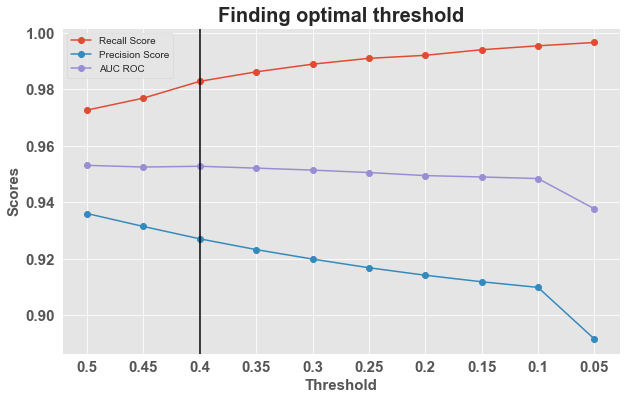

In [99]:
# let's see how lower threshold value affects our model
list_threshold, list_type2_errors, list_recall_score, list_precision_score, list_rocauc_score = [], [], [], [], []

# trying with different threshold values
for i in range(1,11):
    y_pred_iter = binarize(y_pred, i/20)[:,1]
    list_threshold.append(i/20)
    list_type2_errors.append(confusion_matrix(y_train_downsampled_bootstrap, y_pred_iter)[1,0])
    list_recall_score.append(recall_score(y_train_downsampled_bootstrap, y_pred_iter))
    list_precision_score.append(precision_score(y_train_downsampled_bootstrap, y_pred_iter))
    list_rocauc_score.append(roc_auc_score(y_train_downsampled_bootstrap, y_pred_iter))

# # comparing the results
# pd.DataFrame(zip(list_threshold, list_type2_errors, list_recall_score, list_precision_score, list_rocauc_score),
#              columns=["Threshold","Type II errors","Recall","Precision","ROC_AUC"])

# optimal threshold
plt.figure(figsize=(10,6))
plt.plot(list_recall_score[::-1], marker='o', label='Recall Score')
plt.plot(list_precision_score[::-1], marker='o', label='Precision Score')
plt.plot(list_rocauc_score[::-1], marker='o', label='AUC ROC')
plt.axvline(x=2, c='black')
plt.xticks(ticks=range(10), labels=[(i/20) for i in range(1,11)][::-1], fontsize=15, fontweight='bold')
plt.xlabel('Threshold', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.ylabel('Scores', fontsize=15, fontweight='bold')
plt.title('Finding optimal threshold', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

### Observations:

From the above plot, we choose the best threshold value to be 0.4.

In [100]:
# evaluating model using K-fold cross validation
scores = StratifiedKFoldCV(model_base, X_train_downsampled_bootstrap, y_train_downsampled_bootstrap, 5, 0.4)

In [101]:
# checking for overfitting
print(f"Train accuracy: {np.array(scores['train_accuracy']).mean().round(2)}\tTest accuracy: {np.array(scores['test_accuracy']).mean().round(2)}")
print(f"Train F1 score: {np.array(scores['train_f1']).mean().round(2)}\tTest F1 score: {np.array(scores['test_f1']).mean().round(2)}")
print(f"Train ROC AUC: {np.array(scores['train_roc_auc']).mean().round(2)}\tTest ROC AUC: {np.array(scores['test_roc_auc']).mean().round(2)}")

Train accuracy: 0.95	Test accuracy: 0.95
Train F1 score: 0.95	Test F1 score: 0.95
Train ROC AUC: 0.95	Test ROC AUC: 0.95


### Observations:

Train and test scores are similar, there is no model over-fit.

In [102]:
# itereation results
description = "Base logit model with 0.4 threshold"
misclassifications = int(np.array(scores['test_misclassification']).mean())
type1 = int(np.array(scores['test_type1']).mean().round())
type2 = int(np.array(scores['test_type2']).mean().round())
precision = np.array(scores['test_precision']).mean().round(2)
recall = np.array(scores['test_recall']).mean().round(2)
accuracy = np.array(scores['test_accuracy']).mean().round(2)
f1 = np.array(scores['test_f1']).mean().round(2)
auc = np.array(scores['test_roc_auc']).mean().round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95
0,Base logit model with 0.4 threshold,4722,3865,858,0.93,0.98,0.95,0.95,0.95


### Observations:

Using threshold value of 0.4, there is slight improvement in model performance (Recall and Type II errors) at the expense of some Precision and Type I errors.

## Testing on unseen data

In [103]:
# model hyper-parameters
model_base

LogisticRegression(penalty='none')

In [104]:
# fitting model on train data
model_base.fit(X_train_downsampled_bootstrap, y_train_downsampled_bootstrap)

LogisticRegression(penalty='none')

In [105]:
# predicting probablities on test data
y_pred_prob = model_base.predict_proba(X_test)

# binarizing the probablities using threshold value of 0.4
y_pred = binarize(y_pred_prob, 0.4)[:,1]

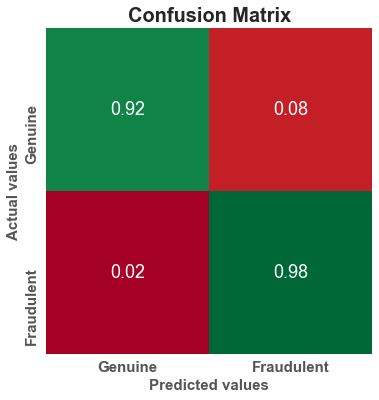

In [106]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
# normalizing
cm = cm / cm.sum(axis=1).reshape(-1,1)
# plotting
cm = pd.DataFrame(cm,
                  columns=['Genuine','Fraudulent'],
                  index=['Genuine','Fraudulent'])
cm = cm.round(2)
plt.figure(figsize=(6,6))
sns.heatmap(cm, cmap="RdYlGn", annot=True, cbar=False, square=True, annot_kws={"fontsize":18})
plt.xlabel("Predicted values", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold')
plt.ylabel("Actual values", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Confusion Matrix", fontsize=20, fontweight='bold')
plt.show()

In [107]:
# itereation results
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
description = "Best logit model - Test data"
misclassifications = fp+fn
type1 = fp
type2 = fn
precision = precision_score(y_test, y_pred).round(2)
recall = recall_score(y_test, y_pred).round(2)
accuracy = accuracy_score(y_test, y_pred).round(2)
f1 = f1_score(y_test, y_pred).round(2)
auc = roc_auc_score(y_test, y_pred).round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95
0,Base logit model with 0.4 threshold,4722,3865,858,0.93,0.98,0.95,0.95,0.95
0,Best logit model - Test data,42599,42564,35,0.04,0.98,0.92,0.07,0.95


### Observations:

Model performance on test data is very good.

## Model Interpretation 

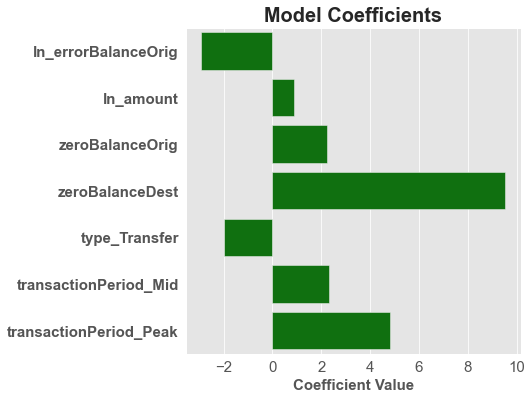

In [108]:
# model coefficients
model_coef = pd.DataFrame(zip(X_train_downsampled_bootstrap.columns,
                              model_base.coef_[0]),
                          columns=["Feature", "Coefficient"])

# visualizing the values
plt.figure(figsize=(6,6))
sns.barplot(data = model_coef,
            y = "Feature",
            x = "Coefficient",
            color = "green")
plt.title("Model Coefficients", fontsize=20, fontweight="bold")
plt.xlabel("Coefficient Value", fontsize=15, fontweight="bold")
plt.xticks(fontsize=15)
plt.ylabel("")
plt.yticks(fontsize=15, fontweight="bold")
plt.show()

### Observations:

Top 3 important features are: zeroBalanceDest, transactionPeriod_Peak, ln_errorBalanceOrig.
<br/>
ln_errorBalanceOrig and type_Transfer have negative effect on the likelihood of fraud, rest of the features are having positive effect on likelihood of fraud.

# Decision Tree Classifier
- Non-linear model
- Non-parametric model
- Simple model

In [109]:
#Base Model
# logit model with default hyperparameters
model_base = DecisionTreeClassifier()
model_base

DecisionTreeClassifier()

In [110]:
# evaluating model using K-fold cross validation
scores = StratifiedKFoldCV(model_base, X_train_downsampled_bootstrap, y_train_downsampled_bootstrap, 5)

In [111]:
# checking for overfitting
print(f"Train accuracy: {np.array(scores['train_accuracy']).mean().round(2)}\tTest accuracy: {np.array(scores['test_accuracy']).mean().round(2)}")
print(f"Train F1 score: {np.array(scores['train_f1']).mean().round(2)}\tTest F1 score: {np.array(scores['test_f1']).mean().round(2)}")
print(f"Train ROC AUC: {np.array(scores['train_roc_auc']).mean().round(2)}\tTest ROC AUC: {np.array(scores['test_roc_auc']).mean().round(2)}")

Train accuracy: 1.0	Test accuracy: 1.0
Train F1 score: 1.0	Test F1 score: 1.0
Train ROC AUC: 1.0	Test ROC AUC: 1.0


### Observations:

Train and test scores are similar, there is no model over-fit.
<br/>
But, wait a minute, a perfect model..? Let's look at other metrics too.

In [112]:
# itereation results
description = "Base decision tree clf model on bootstrapped data"
misclassifications = int(np.array(scores['test_misclassification']).mean())
type1 = int(np.array(scores['test_type1']).mean().round())
type2 = int(np.array(scores['test_type2']).mean().round())
precision = np.array(scores['test_precision']).mean().round(2)
recall = np.array(scores['test_recall']).mean().round(2)
accuracy = np.array(scores['test_accuracy']).mean().round(2)
f1 = np.array(scores['test_f1']).mean().round(2)
auc = np.array(scores['test_roc_auc']).mean().round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95
0,Base logit model with 0.4 threshold,4722,3865,858,0.93,0.98,0.95,0.95,0.95
0,Best logit model - Test data,42599,42564,35,0.04,0.98,0.92,0.07,0.95
0,Base decision tree clf model on bootstrapped data,282,283,0,0.99,1.0,1.0,1.0,1.0


### Observations:

Base decision tree classifier with default hyperparameters model performance is 100%, zero Type II errors. WOW!!
<br/>
Now let's try to prune the tree and reduce the model complexity, and see if we can still get similar results with a simpler tree.

## Hyper-parameter tuning

In [113]:
# hyper-parameter tuning
# creating hyperparameter grid
dict_params = {"max_depth" : [3, 4, 5, 6, 8, 10],
               "criterion" : ['gini', 'entropy'],
               "max_features" : ['sqrt', None]}

# hyperparameter tuning using grid search CV
model_tuning = GridSearchCV(model_base, param_grid=dict_params, scoring='recall', cv=5, return_train_score=True, n_jobs=-1)
model_tuning.fit(X_train_downsampled_smote, y_train_downsampled_smote)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 8, 10],
                         'max_features': ['sqrt', None]},
             return_train_score=True, scoring='recall')

In [114]:
# hyperparameter tuning results
cv_results = pd.DataFrame(model_tuning.cv_results_)
cv_results['train_test_diff'] = cv_results['mean_train_score'] - cv_results['mean_test_score']
cv_results.sort_values('mean_test_score', ascending=False)[["param_max_depth","param_criterion","param_max_features","mean_train_score","mean_test_score",'train_test_diff']].head()

,param_max_depth,param_criterion,param_max_features,mean_train_score,mean_test_score,train_test_diff
13,3,entropy,None,0.996792,0.996792,-2.220446e-16
3,4,gini,None,0.996792,0.996792,-2.220446e-16
15,4,entropy,None,0.996792,0.996792,-2.220446e-16
1,3,gini,None,0.996792,0.996792,-2.220446e-16
5,5,gini,None,0.996620,0.996616,4.000000e-06


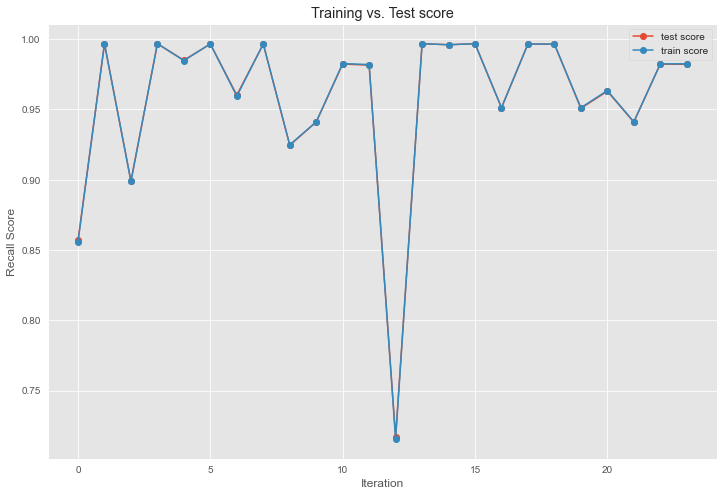

In [115]:
# visualizing training and testing accuracy
plt.figure(figsize=(12,8))
plt.plot(cv_results.index, cv_results["mean_test_score"], label="test score", marker='o')
plt.plot(cv_results.index, cv_results["mean_train_score"], label="train score", marker='o')
plt.title("Training vs. Test score")
plt.ylabel("Recall Score")
plt.xlabel("Iteration")
plt.legend()
plt.show()

### Observations:

From the CV results, there is no difference in train and test performance.
<br/>
Best model parameters: max_depth = 3, criterion = 'gini', max_features = None.

In [116]:
# optimized decision tree classifier model
model_optimized = DecisionTreeClassifier(max_depth=3)
model_optimized

DecisionTreeClassifier(max_depth=3)

In [117]:
# evaluating model using K-fold cross validation
scores = StratifiedKFoldCV(model_optimized, X_train_downsampled_bootstrap, y_train_downsampled_bootstrap, 5)

In [118]:
# checking for overfitting
print(f"Train accuracy: {np.array(scores['train_accuracy']).mean().round(2)}\tTest accuracy: {np.array(scores['test_accuracy']).mean().round(2)}")
print(f"Train F1 score: {np.array(scores['train_f1']).mean().round(2)}\tTest F1 score: {np.array(scores['test_f1']).mean().round(2)}")
print(f"Train ROC AUC: {np.array(scores['train_roc_auc']).mean().round(2)}\tTest ROC AUC: {np.array(scores['test_roc_auc']).mean().round(2)}")

Train accuracy: 0.95	Test accuracy: 0.95
Train F1 score: 0.95	Test F1 score: 0.95
Train ROC AUC: 0.95	Test ROC AUC: 0.95


### Observations:

Train and test scores are similar, there is no model over-fit.

In [119]:
# itereation results
description = "Optimized decision tree clf"
misclassifications = int(np.array(scores['test_misclassification']).mean())
type1 = int(np.array(scores['test_type1']).mean().round())
type2 = int(np.array(scores['test_type2']).mean().round())
precision = np.array(scores['test_precision']).mean().round(2)
recall = np.array(scores['test_recall']).mean().round(2)
accuracy = np.array(scores['test_accuracy']).mean().round(2)
f1 = np.array(scores['test_f1']).mean().round(2)
auc = np.array(scores['test_roc_auc']).mean().round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95
0,Base logit model with 0.4 threshold,4722,3865,858,0.93,0.98,0.95,0.95,0.95
0,Best logit model - Test data,42599,42564,35,0.04,0.98,0.92,0.07,0.95
0,Base decision tree clf model on bootstrapped data,282,283,0,0.99,1.0,1.0,1.0,1.0
0,Optimized decision tree clf,4970,4793,178,0.91,1.0,0.95,0.95,0.95


### Observations:

Pruning the tree and setting the max depth to 3 had degraded model performance.
<br/>
But, the pruned tree performance is definitely better than best logit model performance.

## Testing in unseen data

In [120]:
# model hyper-parameters
model_optimized

DecisionTreeClassifier(max_depth=3)

In [121]:
# fitting model on train data
model_optimized.fit(X_train_downsampled_bootstrap, y_train_downsampled_bootstrap)

DecisionTreeClassifier(max_depth=3)

In [122]:
# predicting probablities on test data
y_pred = model_optimized.predict(X_test)

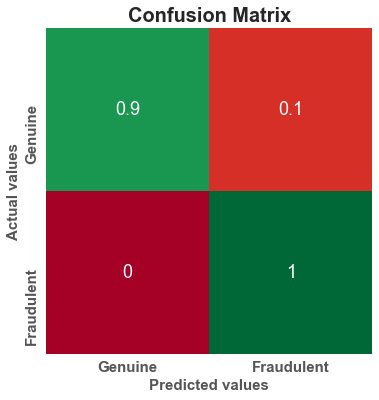

In [123]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
# normalizing
cm = cm / cm.sum(axis=1).reshape(-1,1)
# plotting
cm = pd.DataFrame(cm,
                  columns=['Genuine','Fraudulent'],
                  index=['Genuine','Fraudulent'])
cm = cm.round(2)
plt.figure(figsize=(6,6))
sns.heatmap(cm, cmap="RdYlGn", annot=True, cbar=False, square=True, annot_kws={"fontsize":18})
plt.xlabel("Predicted values", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold')
plt.ylabel("Actual values", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Confusion Matrix", fontsize=20, fontweight='bold')
plt.show()

In [124]:
# itereation results
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
description = "Best decision tree clf - Test data"
misclassifications = fp+fn
type1 = fp
type2 = fn
precision = precision_score(y_test, y_pred).round(2)
recall = recall_score(y_test, y_pred).round(2)
accuracy = accuracy_score(y_test, y_pred).round(2)
f1 = f1_score(y_test, y_pred).round(2)
auc = roc_auc_score(y_test, y_pred).round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results


,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95
0,Base logit model with 0.4 threshold,4722,3865,858,0.93,0.98,0.95,0.95,0.95
0,Best logit model - Test data,42599,42564,35,0.04,0.98,0.92,0.07,0.95
0,Base decision tree clf model on bootstrapped data,282,283,0,0.99,1.0,1.0,1.0,1.0
0,Optimized decision tree clf,4970,4793,178,0.91,1.0,0.95,0.95,0.95
0,Best decision tree clf - Test data,52912,52906,6,0.03,1.0,0.9,0.06,0.95


### Observations:

Compared to logit model, decision tree classifier has improved performance on test data. Reduced type II errors and improved recall score.
<br/>
Let's see if we can reduce the number of type I errors keeping the type II errors similar to decision tree classifier model performance using complex models.

## Model interpretation

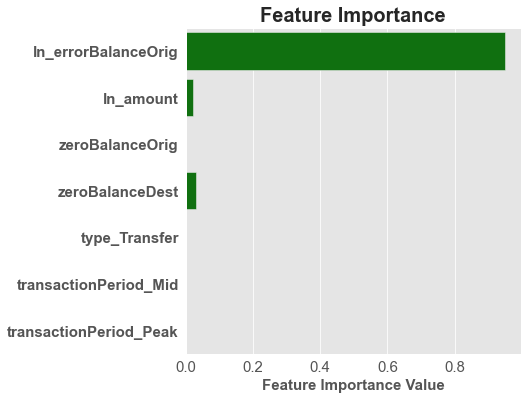

In [125]:
# model coefficients
model_coef = pd.DataFrame(zip(X_train_downsampled_bootstrap.columns,
                              model_optimized.feature_importances_),
                          columns=["Feature", "Coefficient"])

# visualizing the values
plt.figure(figsize=(6,6))
sns.barplot(data = model_coef,
            y = "Feature",
            x = "Coefficient",
            color = "green")
plt.title("Feature Importance", fontsize=20, fontweight="bold")
plt.xlabel("Feature Importance Value", fontsize=15, fontweight="bold")
plt.xticks(fontsize=15)
plt.ylabel("")
plt.yticks(fontsize=15, fontweight="bold")
plt.show()


### Observations:

ln_errorBalanceOrig is the most important feature.
<br/>
ln_amount and zeroBalanceDest also have some importance.

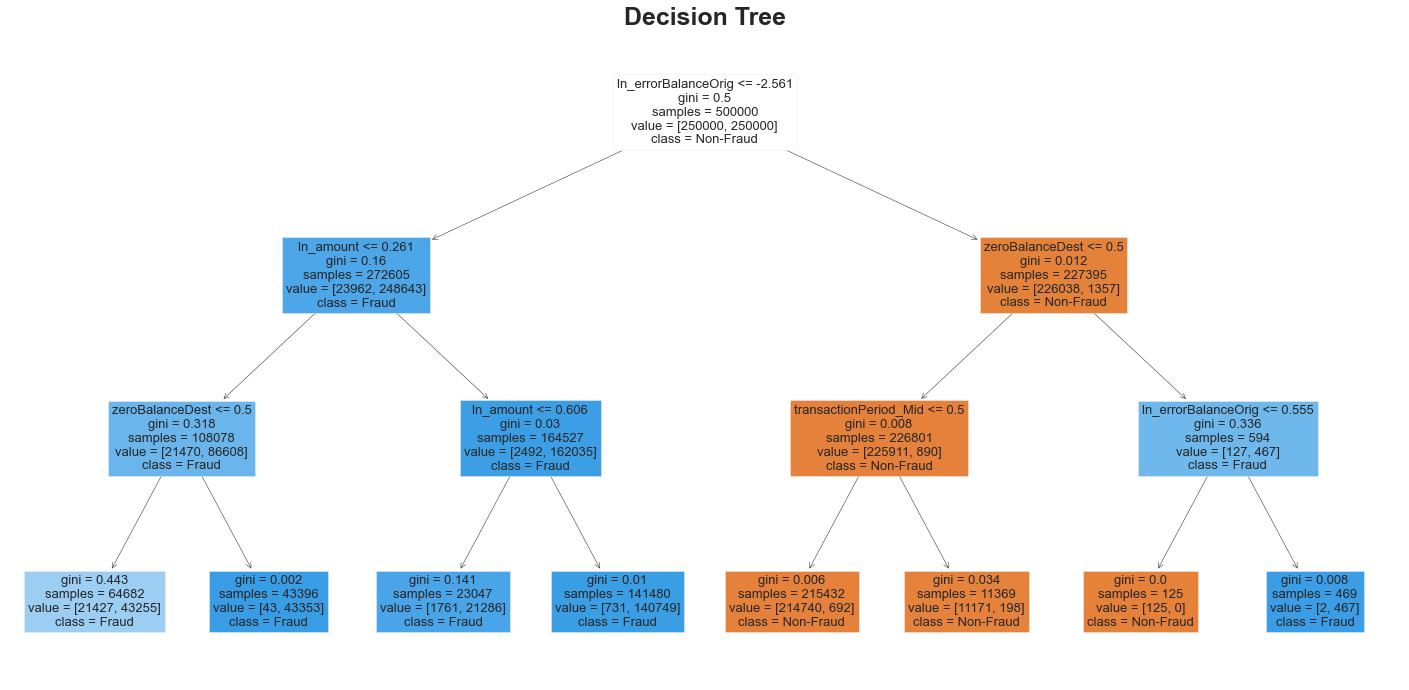

In [126]:
# plotting the tree
plt.figure(figsize=(25,12))
plot_tree(model_optimized, feature_names=X_train_downsampled_bootstrap.columns, class_names=['Non-Fraud','Fraud'], filled=True, fontsize=13)
plt.title("Decision Tree", fontsize=25, fontweight="bold")
plt.show()

### Observations:

We can see that majority of the classification happens one the first and second (right side) nodes.

### Feed-forward Nueral Network
- Non-liner model
- Parametric model
- Complex model

In [127]:
# normalizing train data
# initializing min_max scaler
mms = MinMaxScaler()

# fitting scaler with train data
mms.fit(df_train[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']])

# transforming train data
X_train = pd.DataFrame(mms.transform(df_train[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']]),
                       columns=['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount'])

# creating dummies for test data
X_train['zeroBalanceOrig'] = df_train['zeroBalanceOrig'].reset_index(drop=True)
X_train['zeroBalanceDest'] = df_train['zeroBalanceDest'].reset_index(drop=True)

X_train['type_Transfer'] = df_train['type'].replace({'CASH_OUT' : 0,
                                                     'TRANSFER' : 1})\
                                           .reset_index(drop=True)

X_train['transactionPeriod_Mid'] = df_train['transactionPeriod'].apply(lambda x: 1 if x == 'Mid' else 0)\
                                                                .reset_index(drop=True)
X_train['transactionPeriod_Peak'] = df_train['transactionPeriod'].apply(lambda x: 1 if x == 'Peak' else 0)\
                                                                 .reset_index(drop=True)
# target variable
y_train = df_train['isFraud'].reset_index(drop=True)

# normalizing test data
X_test = pd.DataFrame(mms.transform(df_test[['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount']]),
                      columns=['ln_errorBalanceOrig','ln_errorBalanceDest','ln_amount'])

# creating dummies for test data
X_test['zeroBalanceOrig'] = df_test['zeroBalanceOrig'].reset_index(drop=True)
X_test['zeroBalanceDest'] = df_test['zeroBalanceDest'].reset_index(drop=True)

X_test['type_Transfer'] = df_test['type'].replace({'CASH_OUT' : 0,
                                                   'TRANSFER' : 1})\
                                         .reset_index(drop=True)

X_test['transactionPeriod_Mid'] = df_test['transactionPeriod'].apply(lambda x: 1 if x == 'Mid' else 0)\
                                                              .reset_index(drop=True)
X_test['transactionPeriod_Peak'] = df_test['transactionPeriod'].apply(lambda x: 1 if x == 'Peak' else 0)\
                                                               .reset_index(drop=True)

# target variable
y_test = df_test['isFraud'].reset_index(drop=True)

In [128]:
# Down sampling majority class and up sampling minority class
# down sampling majority class
X_train = pd.concat([X_train[y_train == 0].sample(1000000, random_state=1),
                     X_train[y_train == 1]])
y_train = y_train.iloc[X_train.index]

# dataframe dimensions
print(f"After downsampling the majority class, the imbalanced train set has {X_train.shape[0]} rows and {X_train.shape[1]} columns.")

After downsampling the majority class, the imbalanced train set has 1006570 rows and 8 columns.


In [130]:
# up sampling minority class using SMOTE
# initializing SMOTE object
smote = SMOTE(random_state=33)

# fitting data with SMOTE and creating synthetic over-sampled data set
X_train, y_train = smote.fit_resample(X_train, y_train)

# dataframe dimensions
print(f"After downsampling the majority class and upsampling the minority class using SMOTE, the balanced train set has {X_train.shape[0]} rows and {X_train.shape[1]} columns.")

After downsampling the majority class and upsampling the minority class using SMOTE, the balanced train set has 2000000 rows and 8 columns.


In [131]:
# shuffling data
X_train = X_train.sample(frac=1, random_state=33)
y_train = y_train.sample(frac=1, random_state=33)

In [132]:
# creating dummies for target variable
y_train_binary = pd.get_dummies(y_train)

## Setting parameters

In [133]:
# checking for GPU
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [134]:
# below are hyperparameters used for the experiments
batch_size=40
num_epochs=5
validate_pct=0.1
learning_rate = 1e-3
loss_function='binary_crossentropy'
optimization_function=keras.optimizers.RMSprop(0.001)
metric=[keras.metrics.BinaryAccuracy()]

### Feed forward neural network (32+16)

In [135]:
# simple feed forward NN
model_ann = Sequential()
model_ann.add(InputLayer(input_shape=(8,)))
model_ann.add(Dense(32, activation='relu'))
# model_ann.add(Dropout(0.3))
model_ann.add(Dense(16, activation='relu'))
# model_ann.add(Dropout(0.3))
# model_ann.add(Dense(8, activation='relu'))
# model_ann.add(Dropout(0.3))
model_ann.add(Dense(2, activation='softmax'))

# model framework
model_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 850
Trainable params: 850
Non-trainable params: 0
_________________________________________________________________


In [136]:
# training ANN
model_ann.compile(loss=loss_function, optimizer=optimization_function, metrics=metric)
model_history = model_ann.fit(X_train, y_train_binary,
                              batch_size=batch_size,
                              epochs=num_epochs,
                              validation_split=validate_pct,
                              shuffle=True,
                              verbose=True)

Epoch 1/5
45000/45000 [==============================] - 40s 872us/step - loss: 0.0958 - binary_accuracy: 0.9546 - val_loss: 0.0921 - val_binary_accuracy: 0.9546
Epoch 2/5
45000/45000 [==============================] - 28s 633us/step - loss: 0.0933 - binary_accuracy: 0.9548 - val_loss: 0.0928 - val_binary_accuracy: 0.9546
Epoch 3/5
45000/45000 [==============================] - 31s 679us/step - loss: 0.0931 - binary_accuracy: 0.9547 - val_loss: 0.0928 - val_binary_accuracy: 0.9553
Epoch 4/5
45000/45000 [==============================] - 29s 652us/step - loss: 0.0944 - binary_accuracy: 0.9546 - val_loss: 0.0962 - val_binary_accuracy: 0.9550
Epoch 5/5
45000/45000 [==============================] - 29s 637us/step - loss: 0.0958 - binary_accuracy: 0.9545 - val_loss: 0.0933 - val_binary_accuracy: 0.9545


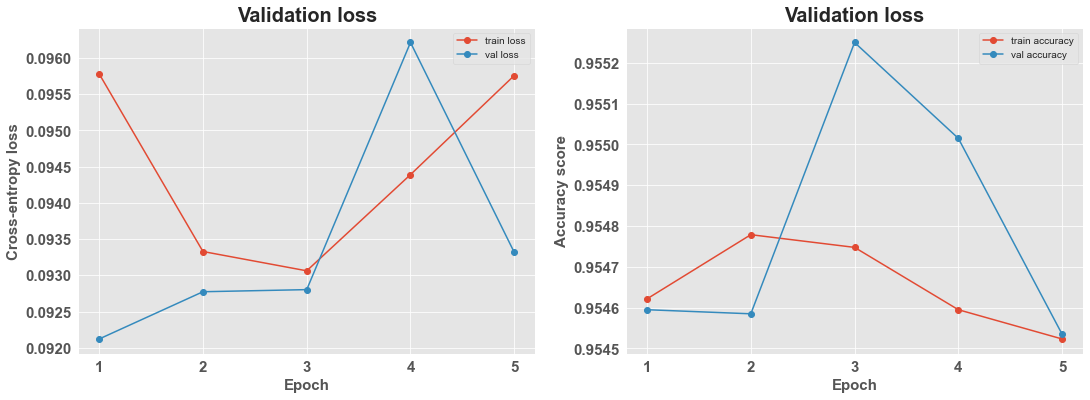

In [137]:
# validation loss and accuracy
plt.subplots(1,2, figsize=(18,6))

# validation loss
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], marker='o', label='train loss')
plt.plot(model_history.history['val_loss'], marker='o', label='val loss')
plt.xlabel("Epoch", fontsize=15, fontweight='bold')
plt.xticks(ticks=range(5), labels=range(1,6), fontsize=15, fontweight='bold')
plt.ylabel("Cross-entropy loss", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Validation loss", fontsize=20, fontweight='bold')
plt.legend()

# validation accuracy
plt.subplot(1,2,2)
plt.plot(model_history.history['binary_accuracy'], marker='o', label='train accuracy')
plt.plot(model_history.history['val_binary_accuracy'], marker='o', label='val accuracy')
plt.xlabel("Epoch", fontsize=15, fontweight='bold')
plt.xticks(ticks=range(5), labels=range(1,6), fontsize=15, fontweight='bold')
plt.ylabel("Accuracy score", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Validation loss", fontsize=20, fontweight='bold')
plt.legend()

plt.show()

In [138]:
# predicting using train data
y_pred = pd.DataFrame(model_ann.predict(X_train))[1].apply(lambda x: 1 if x > 0.5 else 0)


In [139]:
# itereation results
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
description = "Base ANN (32+16)"
misclassifications = fp+fn
type1 = fp
type2 = fn
precision = precision_score(y_train, y_pred).round(2)
recall = recall_score(y_train, y_pred).round(2)
accuracy = accuracy_score(y_train, y_pred).round(2)
f1 = f1_score(y_train, y_pred).round(2)
auc = roc_auc_score(y_train, y_pred).round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95
0,Base logit model with 0.4 threshold,4722,3865,858,0.93,0.98,0.95,0.95,0.95
0,Best logit model - Test data,42599,42564,35,0.04,0.98,0.92,0.07,0.95
0,Base decision tree clf model on bootstrapped data,282,283,0,0.99,1.0,1.0,1.0,1.0
0,Optimized decision tree clf,4970,4793,178,0.91,1.0,0.95,0.95,0.95
0,Best decision tree clf - Test data,52912,52906,6,0.03,1.0,0.9,0.06,0.95
0,Base ANN (32+16),91132,44510,46622,0.96,0.95,0.95,0.95,0.95


### Observations:

Base ANN model is performing well, but not as good as the best logit model or best decision tree classifier.
<br/>
Let's try to improve the complexity.

## Feed forward neural network (64+32)

In [140]:
# simple feed forward NN
model_ann = Sequential()
model_ann.add(InputLayer(input_shape=(8,)))
model_ann.add(Dense(64, activation='relu'))
# model_ann.add(Dropout(0.3))
model_ann.add(Dense(32, activation='relu'))
# model_ann.add(Dropout(0.3))
# model_ann.add(Dense(8, activation='relu'))
# model_ann.add(Dropout(0.3))
model_ann.add(Dense(2, activation='softmax'))

# model framework
model_ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 2,722
Trainable params: 2,722
Non-trainable params: 0
_________________________________________________________________


In [141]:
# training ANN
model_ann.compile(loss=loss_function, optimizer=optimization_function, metrics=metric)
model_history = model_ann.fit(X_train, y_train_binary,
                              batch_size=batch_size,
                              epochs=num_epochs,
                              validation_split=validate_pct,
                              shuffle=True,
                              verbose=True)

Epoch 1/5
45000/45000 [==============================] - 44s 959us/step - loss: 0.0943 - binary_accuracy: 0.9548 - val_loss: 0.0961 - val_binary_accuracy: 0.9556
Epoch 2/5
45000/45000 [==============================] - 31s 681us/step - loss: 0.0949 - binary_accuracy: 0.9548 - val_loss: 0.0935 - val_binary_accuracy: 0.9557
Epoch 3/5
45000/45000 [==============================] - 31s 691us/step - loss: 0.0981 - binary_accuracy: 0.9547 - val_loss: 0.1002 - val_binary_accuracy: 0.9546
Epoch 4/5
45000/45000 [==============================] - 33s 726us/step - loss: 0.0992 - binary_accuracy: 0.9540 - val_loss: 0.0997 - val_binary_accuracy: 0.9553
Epoch 5/5
45000/45000 [==============================] - 31s 699us/step - loss: 0.0984 - binary_accuracy: 0.9537 - val_loss: 0.1074 - val_binary_accuracy: 0.9445


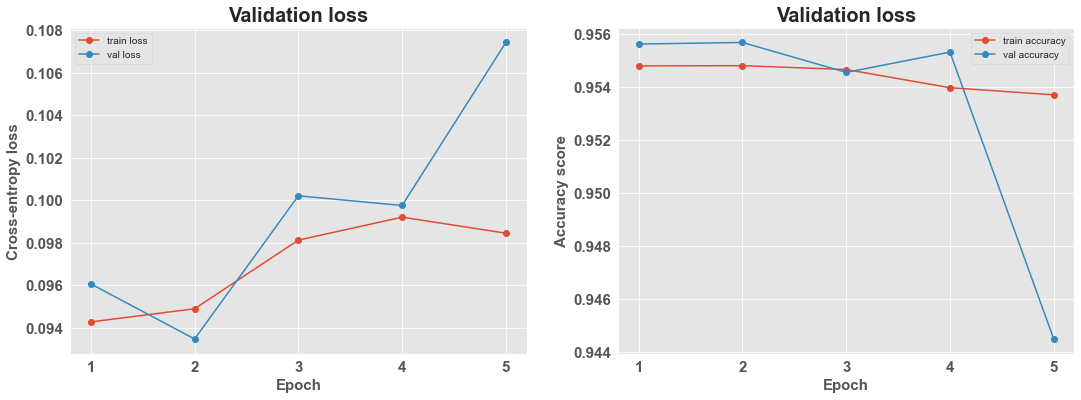

In [142]:
# validation loss and accuracy
plt.subplots(1,2, figsize=(18,6))

# validation loss
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], marker='o', label='train loss')
plt.plot(model_history.history['val_loss'], marker='o', label='val loss')
plt.xlabel("Epoch", fontsize=15, fontweight='bold')
plt.xticks(ticks=range(5), labels=range(1,6), fontsize=15, fontweight='bold')
plt.ylabel("Cross-entropy loss", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Validation loss", fontsize=20, fontweight='bold')
plt.legend()

# validation accuracy
plt.subplot(1,2,2)
plt.plot(model_history.history['binary_accuracy'], marker='o', label='train accuracy')
plt.plot(model_history.history['val_binary_accuracy'], marker='o', label='val accuracy')
plt.xlabel("Epoch", fontsize=15, fontweight='bold')
plt.xticks(ticks=range(5), labels=range(1,6), fontsize=15, fontweight='bold')
plt.ylabel("Accuracy score", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Validation loss", fontsize=20, fontweight='bold')
plt.legend()

plt.show()

In [143]:
# predicting using train data
y_pred = pd.DataFrame(model_ann.predict(X_train))[1].apply(lambda x: 1 if x > 0.5 else 0)

In [144]:
# itereation results
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
description = "ANN (64+32)"
misclassifications = fp+fn
type1 = fp
type2 = fn
precision = precision_score(y_train, y_pred).round(2)
recall = recall_score(y_train, y_pred).round(2)
accuracy = accuracy_score(y_train, y_pred).round(2)
f1 = f1_score(y_train, y_pred).round(2)
auc = roc_auc_score(y_train, y_pred).round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95
0,Base logit model with 0.4 threshold,4722,3865,858,0.93,0.98,0.95,0.95,0.95
0,Best logit model - Test data,42599,42564,35,0.04,0.98,0.92,0.07,0.95
0,Base decision tree clf model on bootstrapped data,282,283,0,0.99,1.0,1.0,1.0,1.0
0,Optimized decision tree clf,4970,4793,178,0.91,1.0,0.95,0.95,0.95
0,Best decision tree clf - Test data,52912,52906,6,0.03,1.0,0.9,0.06,0.95
0,Base ANN (32+16),91132,44510,46622,0.96,0.95,0.95,0.95,0.95
0,ANN (64+32),111646,13981,97665,0.98,0.9,0.94,0.94,0.94


### Observations:

Adding layers improved model performance by a little.
<br/>
Let's try adding dropout layers.

## Feed forward neural network (64+32+8+dropout)

In [145]:
# simple feed forward NN
model_ann = Sequential()
model_ann.add(InputLayer(input_shape=(8,)))
model_ann.add(Dense(64, activation='relu'))
model_ann.add(Dropout(0.2))
model_ann.add(Dense(32, activation='relu'))
model_ann.add(Dropout(0.2))
model_ann.add(Dense(8, activation='relu'))
model_ann.add(Dropout(0.1))
model_ann.add(Dense(2, activation='softmax'))

# model framework
model_ann.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                

In [146]:
# training ANN
model_ann.compile(loss=loss_function, optimizer=optimization_function, metrics=metric)
model_history = model_ann.fit(X_train, y_train_binary,
                              batch_size=batch_size,
                              epochs=num_epochs,
                              validation_split=validate_pct,
                              shuffle=True,
                              verbose=True)

Epoch 1/5
45000/45000 [==============================] - 56s 1ms/step - loss: 0.1046 - binary_accuracy: 0.9528 - val_loss: 0.0939 - val_binary_accuracy: 0.9546
Epoch 2/5
45000/45000 [==============================] - 43s 947us/step - loss: 0.1026 - binary_accuracy: 0.9541 - val_loss: 0.1036 - val_binary_accuracy: 0.9553
Epoch 3/5
45000/45000 [==============================] - 42s 929us/step - loss: 0.1046 - binary_accuracy: 0.9542 - val_loss: 0.0965 - val_binary_accuracy: 0.9551
Epoch 4/5
45000/45000 [==============================] - 43s 945us/step - loss: 0.1059 - binary_accuracy: 0.9539 - val_loss: 0.1007 - val_binary_accuracy: 0.9551
Epoch 5/5
45000/45000 [==============================] - 43s 946us/step - loss: 0.1071 - binary_accuracy: 0.9538 - val_loss: 0.0978 - val_binary_accuracy: 0.9554


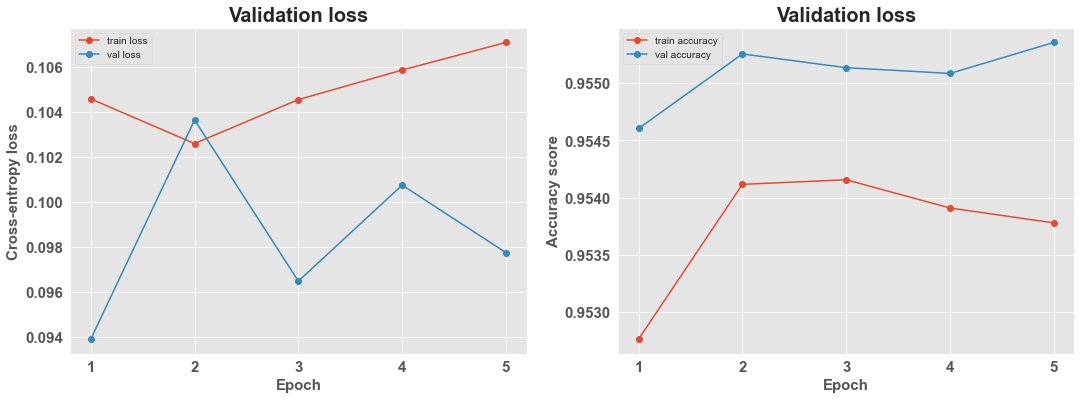

In [147]:
# validation loss and accuracy
plt.subplots(1,2, figsize=(18,6))

# validation loss
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], marker='o', label='train loss')
plt.plot(model_history.history['val_loss'], marker='o', label='val loss')
plt.xlabel("Epoch", fontsize=15, fontweight='bold')
plt.xticks(ticks=range(5), labels=range(1,6), fontsize=15, fontweight='bold')
plt.ylabel("Cross-entropy loss", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Validation loss", fontsize=20, fontweight='bold')
plt.legend()

# validation accuracy
plt.subplot(1,2,2)
plt.plot(model_history.history['binary_accuracy'], marker='o', label='train accuracy')
plt.plot(model_history.history['val_binary_accuracy'], marker='o', label='val accuracy')
plt.xlabel("Epoch", fontsize=15, fontweight='bold')
plt.xticks(ticks=range(5), labels=range(1,6), fontsize=15, fontweight='bold')
plt.ylabel("Accuracy score", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Validation loss", fontsize=20, fontweight='bold')
plt.legend()

plt.show()

In [148]:
# predicting using train data
y_pred = pd.DataFrame(model_ann.predict(X_train))[1].apply(lambda x: 1 if x > 0.5 else 0)

In [149]:
# itereation results
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
description = "ANN (64+32+8+dropout 0.2)"
misclassifications = fp+fn
type1 = fp
type2 = fn
precision = precision_score(y_train, y_pred).round(2)
recall = recall_score(y_train, y_pred).round(2)
accuracy = accuracy_score(y_train, y_pred).round(2)
f1 = f1_score(y_train, y_pred).round(2)
auc = roc_auc_score(y_train, y_pred).round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95
0,Base logit model with 0.4 threshold,4722,3865,858,0.93,0.98,0.95,0.95,0.95
0,Best logit model - Test data,42599,42564,35,0.04,0.98,0.92,0.07,0.95
0,Base decision tree clf model on bootstrapped data,282,283,0,0.99,1.0,1.0,1.0,1.0
0,Optimized decision tree clf,4970,4793,178,0.91,1.0,0.95,0.95,0.95
0,Best decision tree clf - Test data,52912,52906,6,0.03,1.0,0.9,0.06,0.95
0,Base ANN (32+16),91132,44510,46622,0.96,0.95,0.95,0.95,0.95
0,ANN (64+32),111646,13981,97665,0.98,0.9,0.94,0.94,0.94


### Observations:

Adding dropout layers did improve the model performance.
<br/>
Let's test it on unseen (test) data.

In [150]:
# Optimizing treshold
# predicting using train data
y_pred = pd.DataFrame(model_ann.predict(X_train))[1].apply(lambda x: 1 if x > 0.4 else 0)

In [ ]:
# itereation results
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
description = "ANN (64+32+8+dropout 0.2) with 0.4 threshold"
misclassifications = fp+fn
type1 = fp
type2 = fn
precision = precision_score(y_train, y_pred).round(2)
recall = recall_score(y_train, y_pred).round(2)
accuracy = accuracy_score(y_train, y_pred).round(2)
f1 = f1_score(y_train, y_pred).round(2)
auc = roc_auc_score(y_train, y_pred).round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)

# displaying results
df_results

### Observations:

Setting threshold to 0.4 did improve recall a little at the expense of precision and type I errors.

## Testing on unseen data

In [151]:
# network architecture
model_ann.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                

In [152]:
# predicting using test data
y_pred = pd.DataFrame(model_ann.predict(X_test))[1].apply(lambda x: 1 if x > 0.4 else 0)

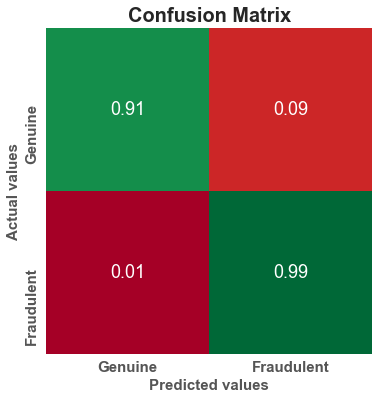

In [153]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
# normalizing
cm = cm / cm.sum(axis=1).reshape(-1,1)
# plotting
cm = pd.DataFrame(cm,
                  columns=['Genuine','Fraudulent'],
                  index=['Genuine','Fraudulent'])
cm = cm.round(2)
plt.figure(figsize=(6,6))
sns.heatmap(cm, cmap="RdYlGn", annot=True, cbar=False, square=True, annot_kws={"fontsize":18})
plt.xlabel("Predicted values", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold')
plt.ylabel("Actual values", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Confusion Matrix", fontsize=20, fontweight='bold')
plt.show()

In [154]:
# itereation results
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
description = "Best ANN model - Test data"
misclassifications = fp+fn
type1 = fp
type2 = fn
precision = precision_score(y_test, y_pred).round(2)
recall = recall_score(y_test, y_pred).round(2)
accuracy = accuracy_score(y_test, y_pred).round(2)
f1 = f1_score(y_test, y_pred).round(2)
auc = roc_auc_score(y_test, y_pred).round(2)

# storing the scores in results dataframe
df_results = pd.concat([df_results,
                        pd.DataFrame(np.array([description,
                                     misclassifications,
                                     type1,
                                     type2,
                                     precision,
                                     recall,
                                     accuracy,
                                     f1,
                                     auc]).reshape(1,-1),
                                     columns=['Description','Misclassifications','Type I errors','Type II errors','Precision','Recall','Accuracy','F1-score','ROC AUC'])
                                  ], axis=0)
# displaying results
df_results

,Description,Misclassifications,Type I errors,Type II errors,Precision,Recall,Accuracy,F1-score,ROC AUC
0,Base logit model on bootstrapped data,4692,3324,1368,0.94,0.97,0.95,0.95,0.95
0,Base logit model on SMOTE data,4678,3338,1340,0.94,0.97,0.95,0.95,0.95
0,Optimized logit model,4765,3358,1407,0.94,0.97,0.95,0.95,0.95
0,Base logit model with 0.4 threshold,4722,3865,858,0.93,0.98,0.95,0.95,0.95
0,Best logit model - Test data,42599,42564,35,0.04,0.98,0.92,0.07,0.95
0,Base decision tree clf model on bootstrapped data,282,283,0,0.99,1.0,1.0,1.0,1.0
0,Optimized decision tree clf,4970,4793,178,0.91,1.0,0.95,0.95,0.95
0,Best decision tree clf - Test data,52912,52906,6,0.03,1.0,0.9,0.06,0.95
0,Base ANN (32+16),91132,44510,46622,0.96,0.95,0.95,0.95,0.95
0,ANN (64+32),111646,13981,97665,0.98,0.9,0.94,0.94,0.94


### Observations:

ANN did slightly outperform logit model, but it could not outperform decision tree classifier.
<br/>
Decision tree classifier remains the best model.

# TypeI vs TypeII errors trade-off

In [155]:
# dataframe
models = ['Logistic Regression', 'ANN', 'Decision Tree']
type1 = [42564, 47416, 52906]
type2 = [35,20,6]

df_tradeoff = pd.DataFrame(zip(models, type1, type2), columns=['Model','Type I Errors', 'Type II Errors'])
df_tradeoff

,Model,Type I Errors,Type II Errors
0,Logistic Regression,42564,35
1,ANN,47416,20
2,Decision Tree,52906,6


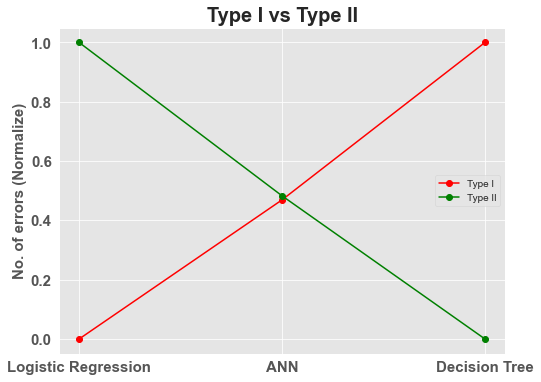

In [156]:
# visualizing
plt.figure(figsize=(8,6))
mms=MinMaxScaler()
plt.plot(mms.fit_transform(df_tradeoff.iloc[:, [1,2]])[:,0], color='r', label='Type I', marker='o')
plt.plot(mms.fit_transform(df_tradeoff.iloc[:, [1,2]])[:,1], color='g', label='Type II', marker='o')
plt.xlabel("", fontsize=15, fontweight='bold')
plt.xticks(ticks=[0,1,2], labels=models, fontsize=15, fontweight='bold')
plt.ylabel("No. of errors (Normalize)", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Type I vs Type II", fontsize=20, fontweight='bold')
plt.legend()
plt.show()

### Observations:

ANN sits in the middle between Logit and Decision Tree Clf models.

# Conclusions
Fraud is a very rare event, approximately only 1 in 1,000 transactions is a fraudulent. Identifying fraudulent transactions could be challenging due to its highly rare nature.

## Where does fraud happen?

- Fraud is observed in Cash Out and Transfer type transactions only.
- Also, fraud is observed in Customer 2 Customer transactions only.

## When does fraud happend?

- Majority of fraudulent transactions happen during night.
- Fraudulent transactions peak between 3am and 6am, and goes as high as 58% of transactions.
- Less than 1% of transactions during day are fraudulent.

## Characteristics of fraudulent transaction amount:

- Proportion of fraudulent transactions in case of transaction amount ending in 0 is little higher than rest of the digits.
- Human beings tend to come up with round numbers when they make-up numbers.

## Cues to identify fraudulent transactions:

- Proportion of fraudulent transactions in case of transaction amount ending in 0 is little higher than rest of the digits.
- Human beings tend to come up with round numbers when they make-up numbers.

## Important features for fraud detection model:
- zeroBalanceDest: Whether the destination account balance amount after the transaction was zero.
- ln_errorBalanceOrig: Log of error in the origin account balance amount after the transaction.
- transactionPeriod_Peak: Whether the transaction was made during peak fraudulent transaction period (midnight).

# Questions to be answered 
#### Note: Please check out the observations at each stage for in detail explanation. 

### 1. Data cleaning including missing values, outliers and multi-collinearity. 
Data cleaning and outlier has been done extensively and there was no need of data cleaning as there was no missing data. Outliers detection has been done by removing skewness using Log Transform.

### 2. Describe your fraud detection model in elaboration. 
We want to build some classification models to predict whether or not a transaction is fraudulent or not, based on the transaction data. In this scenario, we do not want to incorrectly flag fraudulent transaction as non-fraudulent, i.e. incorrectly label (classify) a positive class as negative. Which is a false negative, i.e. Type II errors. I have used SMOTE to do the oversampling and fitting of model. Later I have used three different machine learning algorithms to do the prediction : Logistic regression, Decision tree model and Artificial Neural Networks. Usinh hyper parameter tuning I found oyt the best attributes to be used and later on using some performance measuring metrics I found out the best performing model.

### 3. How did you select variables to be included in the model?
The feature were selected based on our observations from feature engineering and data preprocessing. The correlation method was used to get the final set of features for our model.

### 4. Demonstrate the performance of the model by using best set of tools. 
I have used Misclassifications,Type I errors, Type II errors, Precision, Recall, Accuracy, F1-score and ROC AUC to monitor the performance of the best model out of the three models I've created. Refer to output 154 for details description and observations. It turns out descion tree classifier is the best model for classifying the transactions as fraudulent or not.

### 5. What are the key factors that predict fraudulent customer?
I have used the model coefficients to find the important features that play a role in classifying a transaction as fraudlent ot not. The following are the most important features.
1. zeroBalanceDest
2. ln_errorBalanceOrign
3. transactionPeriod_Peak

### 6. Do these factors make sense? If yes, How? If not, How not? 
These factors do make sense as zeroBlanaceDest tells us whether the destination account amount after transaction was zero or not. These plays an important role as it tells us whether the transaction has actually happened or not or was it fake based on the destination account balance. Ln_errorBalanceOrigin gives us the log of error in the origin account balance amount after the transaction which is basically the log of difference between old and new account balances which makes it an imortant feature as it tells us whether the balance was deducted or not for real. TransactionPeriod_Peak tells us whether the transaction has been made in the peak fraudulent period (mid night) or not. This feature is not as important as the other two but also plays a significant role in classification as it narrows down our data to the transactions that have been made in that hour. 

### 7. What kind of prevention should be adopted while company update its infrastructure?
There are various ways to prevent fraudulent transactions from happening especially in the e-commerce sector. Some ways are:
1. Making sure all of your systems, including your chargeback management provider, are up-to-date is a great way to avoid any mishaps in the buying process for online shoppers. This can be done by appointing some e-commerce fraud protection services
2. Whatever fraud protection system you use, it's a good idea to use one that combines machine learning and human experts to prevent fraud. Having not a robot verifications are very helpful.
3. Employing an address verification system (AVS) to fight against e-commerce fraud. This verifies the address of the person who claims to own the credit card, which helps ensure that the transaction is valid. Card verification value (CVV) technology is also advised. Or verifying through mobile OTPs before transactions to confirm the transactions is also advisable.
4. Identify the origins of transactions. Device assessment helps merchants detect human versus bot interactions, flag malicious intentions and spotlight anomalies associated with account takeovers.Even when the identity and payment data are valid, the device risks identified may heighten the overall transaction risk
5. Provide constant customer support and have the ability to deal with the customers right away in case of any frauds using risk techniques.

### 8. Assuming these actions have been implemented, how would you determine if they work.
After using the above preventive measures, we can make sure if they worked or not by again doing a thorough analysis. Constantly checking the feedbacks and sentiments of the customers we can make sure if any such fraud transactions is taking place or not. Comparing the lastest fraud transactions with the old ones, we can see determine of the preventive measure worked or not. 